
# Hito 2 y 3: Propuesta metodológica experimental inicial, experimentación y análisis de resultados

**Diciembre 2023**

**Universidad de Chile**

___
**Profesores:** Cinthia Sánchez Macías y Jazmine Maldonado.
___
**Auxiliares:** Fran Antonie Zautzik Rojas y María José Zambrano Burrows.
___
**Curso:** Minería de Datos CC5205.
___
**Grupo 11:** David Felipe, Cristian Jara, Alfredo Padilla, Gonzalo Serradilla y Pablo Vergara.

## Importar los datos y librerías
___

Se puede cambiar el *dirección* de los datos. Los datos que se importaron son que se obtuvieron luego de limpiar los datos en el hito 1.

In [1]:
url = "https://raw.githubusercontent.com/davidnfu0/data-mining-en-incendios-de-Chile/main/data/data_incendios_limpio.csv"

In [3]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, silhouette_score, classification_report, pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.mixture import GaussianMixture
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

In [4]:
df = pd.read_csv(url)
df.head()

Region Provincia     Comuna  Temporada            Nombre       Fecha  \
0  Coquimbo     Elqui  La Serena  2002-2003        ALTOVALSOL  2002-07-05   
1  Coquimbo     Elqui  La Serena  2002-2003             CERES  2002-10-25   
2  Coquimbo    Limarí  Punitaqui  2002-2003      LA RINCONADA  2002-10-27   
3  Coquimbo     Elqui   Coquimbo  2002-2003  CERRO LA VIRGEN.  2002-11-02   
4  Coquimbo     Elqui  La Serena  2002-2003        LA VARILLA  2002-11-02   

  HoraInicio  DuracionMinutos      Alerta    Escenario  ...  \
0      21:05            195.0  Sin alerta  No definido  ...   
1      11:50            137.0  Sin alerta  No definido  ...   
2      11:50            190.0  Sin alerta  No definido  ...   
3      17:00             90.0  Sin alerta  No definido  ...   
4      15:30            210.0  Sin alerta  No definido  ...   

  SuperficieQuemadaArbolado  SuperficieQuemadaMatorral  \
0                       0.0                       0.01   
1                       0.0                       0.01   
2                       0.0                       0.00   
3                       0.0                       0.50   
4                       0.0                       2.00   

   SuperficieQuemadaPastizal  SuperficieQuemadaAgricola  \
0                       0.03                        0.0   
1                       0.01                        0.0   
2                       0.01                        0.0   
3                       1.50                        0.0   
4                       5.00                        0.0   

   SuperficieQuemadaDesechos  SuperficieQuemadaTotal    Latitud   Longitud  \
0                        0.0                    0.04 -29.935556 -71.108333   
1                        0.0                    0.02 -29.933611 -71.211944   
2                        0.0                    0.01 -30.833056 -71.368056   
3                        0.0                    2.00 -29.995833 -71.275556   
4                        0.0                    7.00 -29.880000 -71.190000   

   Datum  SuperficieQuemadaPino  
0  WGS84                    0.0  
1  WGS84                    0.0  
2  WGS84                    0.0  
3  WGS84                    0.0  
4  WGS84                    0.0  

[5 rows x 23 columns]

In [5]:
df["Datum"].unique()

array(['WGS84'], dtype=object)

Se puede notar que la columna *Datum* posee el mismo valor para todos los datos, por lo que no aporta información relevante. Por lo tanto, esta columna no se utilizará de aquí en adelante.

In [6]:
df.drop(columns="Datum", inplace=True)

## Preguntas de investigación planteadas en el Hito 1

___
1. ¿Es factible predecir la severidad de un incendio forestal en curso y determinar el nivel de alerta correspondiente basándose en sus características y factores actuales?
___
2. ¿Se pueden usar los registros existentes de incendios para identificar patrones y características predictivas que diferencien entre causas intencionales y no intencionales?
___
3. ¿Se pueden identificar grupos de incendios que compartan características similares, y estos grupos podrían proporcionarnos información valiosa para abordar eficazmente estas situaciones de emergencia?

## Propuesta experimental

A continuación se desarrollará la propuesta experimental que busca dar respuesta a nuestras preguntas.

---

**General para todas la preguntas:**

- Para comenzar, se creará una nueva columna llamada 'Intencional' que tendrá el valor '1' si el incendio es de carácter intencional y '0' si no lo es, en el caso de que la causa no esté definida o sea desconocida el valor de esta columna será 'None'. Además se creará una nueva columna llamada 'Mes' que tendrá el mes en que ocurrió el incendio, pues, es el único dato referente a la fecha que consideramos importante para el estudio, es importante mencionar que este dato se va a almacenar como una variable numérica.
  
- La columna 'Alerta' para el análisis, esta se convertirá en un formato numérico: asignaremos un '0' a los registros de incendios que no posean alerta, '1' para alertas de nivel amarillo, y '2' para las de nivel rojo. Asimismo, modificaremos la columna 'Hora inicio' para reflejar el tiempo transcurrido en minutos desde la medianoche hasta el momento en que se declaró cada incendio, considerando únicamente las horas y minutos. Este ajuste permite una mejor integración de los datos en los modelos predictivos. También se va a modificar la columna escenario, pasandola a datos de tipo númerico para facilitar el uso de modelos.

- Para reducir la cantidad de registros que se van a utilizar, se va a considerar solo los incendios que consideramos más relevantes. El criterio de selección a utilizar es solo considerar los incendios con una superficie total quemada mayor a $0.2[ha]$, que hayan durado más de $15[min]$.

**Pregunta 1:**

- Con el fin de abordar esta consulta, y considerando su naturaleza predictiva, se implementarán técnicas de clasificación multiclase enfocadas en la columna 'Alerta'. Esta columna clasifica la severidad de un incendio en tres categorías: 'Sin Alerta', 'Alerta Amarilla' y 'Alerta Roja'. Para llevar a cabo este análisis, se utilizará un conjunto de 15 variables relevantes: 'Mes', 'Hora inicio', 'Duración Minutos', 'Escenario', 'Región', 'Superficie quemada Pino', 'Superficie quemada Eucalipto', 'Superficie quemada Otras plantas', 'Superficie quemada Arbolado', 'Superficie quemada Matorral', 'Superficie quemada Pastizal', 'Superficie quemada Agrícola', 'Superficie quemada Desechos', 'Superficie quemada total', 'Latitud' y 'Longitud'.

- Es crucial mencionar que se excluirán las columnas 'Causa' e 'Intencional' del análisis. Esto se debe a que, habitualmente, esta información no se conoce con antelación al uso del modelo y, además, se ha observado que numerosos registros carecen de datos precisos sobre la causa del incendio, reduciendo su relevancia para el modelo.

- Adicionalmente, se omitirán las variables 'Comuna', 'Provincia' y 'Región', bajo el supuesto de que su información ya está implícita en las variables 'Latitud' y 'Longitud'. Esta decisión de inclusión de variables también se aplicará en la metodología experimental para la pregunta 2.

- Al analizar el conjunto de datos, se observa que la mayoría de los registros se clasifican en la categoría 'Sin Alerta'. Esto sugiere una tendencia predominante en la clasificación de los incendios, lo cual será un aspecto crucial a considerar en el análisis y en la interpretación de los resultados del modelo de clasificación.


In [7]:
print(pd.value_counts(df["Alerta"], sort=True))

Alerta
Sin alerta         108911
Alerta roja           726
Alerta amarilla       348
Name: count, dtype: int64


C:\Users\David\AppData\Local\Temp\ipykernel_10828\473275906.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(df["Alerta"], sort=True))


- Se implementarán diversos algoritmos de clasificación para abordar esta tarea, incluyendo *Árboles de Decisión*, *KNN (K-Nearest Neighbors)*, *Random Forest* y *Naive Bayes*. Para evaluar y comparar el rendimiento de cada algoritmo, se utilizarán métricas estándar como *Accuracy*, *Precision*, *Recall* y *F1-score*. Se propone dividir los datos en un $90\%$ para el entrenamiento del modelo y un $10\%$ para su evaluación en un conjunto de testeo.

- Dada la presencia de un desbalance significativo en las clases, particularmente la predominancia de la categoría 'Sin Alerta', se aplicará una técnica de *SubSampling* para la clase mayoritaria, al aplicar *SubSampling* va a disminuir mucho la cantidad de datos, por eso se ocupa un $90\%$ de los datos en entrenamiento. Este enfoque busca equilibrar la distribución de las clases y así prevenir un sesgo en el modelo hacia la clase más frecuente. Sin embargo, este método reduce el tamaño del conjunto de datos de entrenamiento. Para mitigar este efecto y garantizar la robustez del modelo, se implementará *Cross Validation*, permitiendo así que el modelo se beneficie de una mayor variedad de datos durante su entrenamiento.

- El proceso de selección de hiperparámetros se realizará mediante *Grid Search* para cada modelo, maximizando el *F1-Score*. Esta búsqueda exhaustiva permitirá identificar la configuración óptima de hiperparámetros que maximiza el rendimiento del modelo. Posteriormente, con estos hiperparámetros seleccionados, se procederá a entrenar los modelos utilizando *Cross Validation* sobre el conjunto de entrenamiento, sobre el cual previamente se aplico *SubSampling*.

- Finalmente, el modelo que muestre el mejor desempeño en las métricas mencionadas será seleccionado sera entrenado y evaluado más a fondo en el conjunto de testeo. Esta evaluación final servirá para determinar la eficacia y aplicabilidad práctica del modelo seleccionado en el contexto de la clasificación de severidad de incendios.

**Pregunta 2:**

- Para responder esta pregunta es importante notar que en el *data frame* existe el atributo *causa*, el cual indica la causa del incendio. Una de las causas es *incendios intencionales*, por lo que se puede usar este atributo para clasificar los incendios en intencionales y no intencionales.

- Dado que la pregunta es de carácter predictivo, nos enfocaremos de manera particular en un modelo de clasificación binaria. Donde se busca predecir la intencionalidad de un incendio en base a sus características. Es decir, buscamos predecir valores de la columna *Intencional*.
  
- Se va a utilizar un conjunto de $16$ características para predecir la intencionalidad de un incendio. Estas son: 'Mes', 'Hora inicio', 'Duración Minutos', 'Alerta', 'Escenario', 'Región', 'Superficie quemada Pino', 'Superficie quemada Eucalipto', 'Superficie quemada Otras plantas', 'Superficie quemada Arbolado', 'Superficie quemada Matorral', 'Superficie quemada Pastizal', 'Superficie quemada Agrícola', 'Superficie quemada Desechos', 'Superficie quemada total', 'Latitud' y 'Longitud'.
  
- Para la evaluar la calidad de la clasificación se van a utilizar diversos algoritmos y compraremos sus métricas. Los algoritmos a utilizar son: *Árboles de Decisión*, *KNN (K-Nearest Neighbors)*, *Random Forest* y *Naive Bayes*. Las métricas a utilizar son: *Accuracy*, *Precision*, *Recall* y *F1-score*. La partición que utilizaremos es de $70\%$ para entrenamiento y $30\%$ para prueba. Además se va a hacer un *SubSampling* de los datos de entrenamiento, pues, la cantidad de incendios intencionales es menor en comparación con los no intencionales. Por lo tanto, se va a disminuir la cantidad de incendios intencionales en el conjunto de entrenamiento.

- Primero se van a seleccionar los mejor hiperparámetros para cada modelos. Para esto se va a utilizar *Grid Search* y se va a maximizar el *F1-score*. Luego se va a entrenar el modelo con los mejores hiperparámetros utilizando *Cross Validation*. Sobre el conjunto de entrenamiento la que previamente se le aplico *SubSampling*.

- Para concluir, el modelo que muestra el mejor desempeño en las métricas mencionadas será seleccionado, para posteriormente entrenarlo con el conjunto de entrenamiento completo. Finalmente, se va a concluir si el modelo es eficaz y aplicable en el contexto de la clasificación de intencionalidad de incendios, evaluando sus métricas en el conjunto de prueba.

**Pregunta 3:**

- Se van utilizar solo incendios cuya intencionalidad sea conocida, es decir, se van a utilizar solo incendios intencionales y no intencionales. Además, se van a utilizar solo incendios que hayan durado más de $15[min]$ y que hayan quemado más de $0.2[ha]$.

- Para poder responder esta pregunta se utilizarán técnicas de *Clustering* que nos permitan reconocer grupos que se forman de manera intrínseca en los datos. Para esto se utilizarán los algoritmos *K-means*, *DBSCAN* y *Gaussian Mixture Models*.

- Se van a utilizar un conjunto de características para generar los *Clusters* y luego, evaluarlos. Las características que se van a utilizar son características numéricas, ya sean continuas o discretas.
  
- Las características que se van a utilizar se van a normalizar, pues, se asume que las características tienen distintas escalas y se quiere que todas tengan el mismo peso al momento de generar los *Clusters*. La normalización está dada por: $x_{norm} = \frac{x - \mu}{\sigma}$, donde $\mu$ es el estimador de momentos de la esperanza y $\sigma$ es el estimador de momentos insesgado de la desviación estándar de la característica $x$

- Para evaluar los *Clusters* se va a usar el enfoque visual creando la matriz de proximidad, para esto se va a aplicar *PCA* para reducir la dimensionalidad de los datos, a solo dos componentes. Además, se van a gráficar los *Clusters* en un plano cartesiano para poder hacer un análisis cualitativo.
  
- También se va a utilizar métricas numéricas para evaluar la calidad de los *Clusters*. Las métricas a utilizar son: *Silhouette Score*, *Cohesión* y *Separación*.
  
- Por otro lado, para elegir una óptima cantidad de *Clusters* se va a utilizar el método del codo (en el caso de *K-means* y *Gaussian Mixture Models*) y el método de la rodilla (en el caso de *DBSCAN*).
  
- Es importante mencionar que los clusters generados, también, se van a evaluar de manera cualitativa.
  
- Por último, se interpretarán los *Clusters* obtenidos y se analizarán las características de los incendios que pertenecen a cada *Cluster*. Para así obtener información relevante y entender que representan.

## Experimentos

En esta sección se realizaran los experimentos para responder las preguntas de investigación planteadas en el hito 1.

### Preliminares

#### Función para eliminar warnings
___

In [8]:
def no_show_warnings() -> None:
    """Elimina los warning del output"""
    warnings.filterwarnings("ignore")
    warnings.warn("DelftStack")
    warnings.warn("Do not show this message")

#### Fijar la semilla de numpy
___

In [9]:
np.random.seed(42)

#### Creación y modificación de variables del Data Frame
___
Aquí se crean y mofican las variables del Data Frame para su posterior uso en los modelos de clasificación, siguiendo lo comentado en la propuesta metodologíca.

In [10]:
# Crear la columna Intencional según cómo fueron etiquetados en la variable Causa
conditions = [
    df["Causa"] == "Incendios intencionales",
    df["Causa"].isin(["No definida", "Incendios de causa desconocida"]),
]
choices = [1, "None"]
df["Intencional"] = np.select(conditions, choices, default=0)

# Crear la columna Mes a partir de la variable Fecha
df["Fecha"] = pd.to_datetime(df["Fecha"], format="%Y-%m-%d")
df["Mes"] = df["Fecha"].dt.month

# Convertir Alerta a valores numéricos
df = df.replace({"Alerta": {"Sin alerta": 0, "Alerta roja": 2, "Alerta amarilla": 1}})

# Convertir Hora inicio a valores numéricos
df["HoraInicio"] = (
    pd.to_datetime(df["HoraInicio"], format="%H:%M").dt.hour * 60
    + pd.to_datetime(df["HoraInicio"], format="%H:%M").dt.minute
)

# Convertir Escenario a valores numéricos
df = df.replace(
    {
        "Escenario": {
            "No definido": 0,
            "IFor-Vn": 1,
            "IFIUr-Fo": 2,
            "IFor-PI": 3,
            "IFASP": 4,
            "IFIns": 5,
            "IFCo": 6,
            "IFSu": 7,
            "IFCSo": 8,
        }
    }
)

In [11]:
df.tail(10)

Region   Provincia     Comuna  Temporada  \
109975            Los Ríos    Valdivia  Mariquina  2019-2020   
109976            Los Ríos    Valdivia  Mariquina  2019-2020   
109977  Arica y Parinacota       Arica  Camarones  2019-2020   
109978  Arica y Parinacota       Arica      Arica  2019-2020   
109979  Arica y Parinacota       Arica      Arica  2019-2020   
109980  Arica y Parinacota       Arica      Arica  2019-2020   
109981  Arica y Parinacota  Parinacota      Putre  2019-2020   
109982  Arica y Parinacota       Arica      Arica  2019-2020   
109983  Arica y Parinacota  Parinacota      Putre  2019-2020   
109984  Arica y Parinacota       Arica  Camarones  2019-2020   

                              Nombre      Fecha  HoraInicio  DuracionMinutos  \
109975             PURINGUE POBRE II 2020-04-07         780             81.0   
109976                        RUCACO 2020-04-11         930             29.0   
109977                     GUATANAVE 2019-07-04         930           1192.0   
109978                LA PONDEROSA I 2019-08-10         797            379.0   
109979               LA PONDEROSA II 2019-08-12         571            194.0   
109980              LA PONDEROSA III 2019-08-13         939             48.0   
109981            CAMINO VIEJO PUTRE 2019-09-18        1167            123.0   
109982                   KM 20 LLUTA 2019-12-08         855            192.0   
109983  RESERVA NACIONAL LAS VICUÑAS 2019-12-10         900           1248.0   
109984                   CAMARONES 1 2020-05-15         616            314.0   

        Alerta  Escenario  ... SuperficieQuemadaMatorral  \
109975       0          1  ...                       0.0   
109976       0          3  ...                       0.0   
109977       0          0  ...                       0.3   
109978       0          0  ...                       0.6   
109979       0          0  ...                       0.0   
109980       0          0  ...                       0.0   
109981       0          0  ...                       0.0   
109982       0          0  ...                       0.0   
109983       0          0  ...                       0.0   
109984       0          0  ...                       0.0   

        SuperficieQuemadaPastizal  SuperficieQuemadaAgricola  \
109975                       0.20                        0.0   
109976                       0.00                        0.0   
109977                       0.19                        0.0   
109978                       2.00                        0.0   
109979                       0.60                        0.0   
109980                       0.01                        0.0   
109981                       0.50                        0.0   
109982                       0.02                        0.0   
109983                       0.50                        0.0   
109984                      18.00                        0.0   

        SuperficieQuemadaDesechos  SuperficieQuemadaTotal    Latitud  \
109975                        0.0                    0.20 -39.471667   
109976                        1.0                    1.75 -39.585000   
109977                        0.0                    0.50 -18.823611   
109978                        0.0                    2.60 -18.420556   
109979                        0.0                    0.60 -18.418056   
109980                        0.0                    0.01 -18.416944   
109981                        0.0                    0.60 -18.187778   
109982                        0.0                    0.02 -18.416944   
109983                        0.0                    0.50 -18.855278   
109984                        0.0                   18.00 -19.004167   

         Longitud  SuperficieQuemadaPino  Intencional  Mes  
109975 -73.001667                    0.0            0    4  
109976 -72.899722                    0.0            0    4  
109977 -69.723611                    0.0            0    7  
109978 -70.317778              

#### Selección de datos
___
En este inciso se van a seleccionar los datos de incendios que consideramos más relevantes. El criterio de selección a utilizar es solo considerar los incendios con una superficie total quemada mayor a $0.2[ha]$ y que hayan durado más de $15[min]$. Además, que tengan la intencionalidad definida. Ahora vamos a separar en dos data frames, uno con los que tienen la intencionalidad definida (`df_mod`) y otro con los que no (`df`).

In [12]:
no_show_warnings()

# Crear el filtro de superficie quemada
filtro_superficie = df['SuperficieQuemadaTotal'] >= 0.2

# Crear el filtro de duración del incendio
filtro_tiempo = df['DuracionMinutos'] >= 15

# Crear el filtro de intencionalidad
filtro_intencionalidad = df['Intencional'] != 'None'
df = df[filtro_superficie & filtro_tiempo]

# Crear el DataFrame mod con el filtro de intencionalidad
df_mod = df[filtro_intencionalidad]
df_mod['Intencional'] = df_mod['Intencional'].astype(int)
print(df.shape)
print(df_mod.shape)

(64793, 24)
(57486, 24)


In [13]:
i = 0
for col in df_mod.columns:
    print(i, ": ", col)
    i += 1

0 :  Region
1 :  Provincia
2 :  Comuna
3 :  Temporada
4 :  Nombre
5 :  Fecha
6 :  HoraInicio
7 :  DuracionMinutos
8 :  Alerta
9 :  Escenario
10 :  Causa
11 :  SuperficieQuemadaEucalipto
12 :  SuperficieQuemadaOtrasPlantas
13 :  SuperficieQuemadaArbolado
14 :  SuperficieQuemadaMatorral
15 :  SuperficieQuemadaPastizal
16 :  SuperficieQuemadaAgricola
17 :  SuperficieQuemadaDesechos
18 :  SuperficieQuemadaTotal
19 :  Latitud
20 :  Longitud
21 :  SuperficieQuemadaPino
22 :  Intencional
23 :  Mes


### Experimento 1
(Pregunta 1)

Las funciones que se van a crear a continuación son para poder evaluar los modelos de clasificación. Se van a utilizar para los experimentos 1 y 2.

#### Selección de las columnas que se van a utilizar para predecir y la que se va a predecir:
___

Seleccionamos las columna siguiendo lo comentado en la propuesta metodológica.

In [14]:
X1 = df.iloc[:, [6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23]].to_numpy()
y1 = df.iloc[:, 8].to_numpy()

#### Separación de los datos en entrenamiento y prueba:
___

Se separan los datos en entrenamiento y prueba, siguiendo lo comentado en la propuesta metodológica.

In [15]:
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.1, random_state=42
)
rus = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X1_train, y1_train = rus.fit_resample(X1_train, y1_train)

In [16]:
print(X1_train.shape)

(882, 15)


#### Selección de los mejores hiperparámetros:
___

En esta sección se va a definir un conjunto de modelos y de hiperparámetros para cada modelo. Estos modelos y hiperparámetros se van a utilizar tanto para resolver la pregunta 1 como la pregunta 2. Para seleccionar los mejores hiperparámetros se va a utilizar *GridSearch*. Para esto se va a utilizar la función `GridSearchCV` de `sklearn.model_selection`. Esta función recibe como parámetros el modelo, los hiperparámetros, el número de *folds* y la métrica a maximizar. Esta función retorna el modelo con los mejores hiperparámetros. Para facilitar la aplicación de esto se va a crear una función que automatice este proceso, esta función se va a utilizar también en para el experimento 2.

In [17]:
def find_best_hyperparameters(models: dict,
                              param_grids: dict,
                              X: np.ndarray,
                              y: np.ndarray,
                              cv: int =5,
                              scoring='f1') -> dict:
    """Devuelve los hiperparámetros que maximicen socoring, siendo este f1"""
    best_params = {}
    for model_name, model in models.items():
        print(f"Buscando los mejores hiperparámetros para {model_name}:")
        if model_name in param_grids:
            grid_search = GridSearchCV(
                model, param_grids[model_name], cv=cv, scoring=scoring, n_jobs=-1)
            grid_search.fit(X, y)
            best_params[model_name] = grid_search.best_params_
            print(
                f"Mejores hiperparámetros para {model_name}: {grid_search.best_params_}")
        else:
            print(f"No se definió un grid de búsqueda para {model_name}")
    return best_params

In [18]:
dt = DecisionTreeClassifier(random_state=42)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=42)
nb = GaussianNB()

models = {
    "Decision Tree": dt,
    "K Nearest Neighbors": knn,
    "Random Forest": rf,
    "Naive Bayes": nb
}

param_grid_dt = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 8]
}

param_grid_knn = {
    'n_neighbors': [5, 10, 15],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_nb = {}  # No tiene hiperparámetros críticos

param_grid = {
    "Decision Tree": param_grid_dt,
    "K Nearest Neighbors": param_grid_knn,
    "Random Forest": param_grid_rf,
    "Naive Bayes": param_grid_nb
}

In [19]:
no_show_warnings()

best_hyperparameters1 = find_best_hyperparameters(
    models=models, X=X1_train, y=y1_train, param_grids=param_grid
)

Buscando los mejores hiperparámetros para Decision Tree:


Mejores hiperparámetros para Decision Tree: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Buscando los mejores hiperparámetros para K Nearest Neighbors:
Mejores hiperparámetros para K Nearest Neighbors: {'metric': 'euclidean', 'n_neighbors': 5}
Buscando los mejores hiperparámetros para Random Forest:
Mejores hiperparámetros para Random Forest: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Buscando los mejores hiperparámetros para Naive Bayes:
Mejores hiperparámetros para Naive Bayes: {}


#### Creación y evaluación de los modelos:
___

En esta sección se van a crear los modelos con los hiperparámetros encontrados antes. Además, se van a evaluar utilizando validación cruzada con 5 *folds* y se van a calcular las métricas *Accuracy*, *Precision*, *Recall* y *F1-score*.

In [20]:
def run_classifier(clf,
                   X: np.ndarray,
                   y: np.ndarray,
                   cv=5) -> str:

    """Evalúa un clasificador con cross validation"""
    y_pred = cross_val_predict(clf, X, y, cv=cv)
    detailed_report = classification_report(y, y_pred)
    return detailed_report

In [21]:
def evaluate_and_print_metrics(models: dict,
                               X: np.ndarray,
                               y: np.ndarray,
                               cv=5) -> None:

    """Evalúa y muestra las métricas de un conjunto de modelos"""
    for model_name, model in models.items():
        print(f"Evaluating model: {model_name}")
        metrics = run_classifier(model, X, y, cv)
        print("\nReporte de clasificación detallado:\n", metrics)
        print("-" * 50)

In [22]:
models1 = models

best_hyperparameters1["Decision Tree"]["random_state"] = 42

models1["Decision Tree"] = DecisionTreeClassifier(
    **best_hyperparameters1["Decision Tree"]

)

models1["K Nearest Neighbors"] = KNeighborsClassifier(
    **best_hyperparameters1["K Nearest Neighbors"]

)

best_hyperparameters1["Random Forest"]["random_state"] = 42

models1["Random Forest"] = RandomForestClassifier(
    **best_hyperparameters1["Random Forest"]

)

models1["Naive Bayes"] = GaussianNB(**best_hyperparameters1["Naive Bayes"])

In [23]:
evaluate_and_print_metrics(models=models1, X=X1_train, y=y1_train)

Evaluating model: Decision Tree

Reporte de clasificación detallado:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84       294
           1       0.66      0.67      0.67       294
           2       0.71      0.72      0.71       294

    accuracy                           0.74       882
   macro avg       0.74      0.74      0.74       882
weighted avg       0.74      0.74      0.74       882

--------------------------------------------------
Evaluating model: K Nearest Neighbors

Reporte de clasificación detallado:
               precision    recall  f1-score   support

           0       0.52      0.69      0.59       294
           1       0.44      0.41      0.43       294
           2       0.54      0.40      0.46       294

    accuracy                           0.50       882
   macro avg       0.50      0.50      0.49       882
weighted avg       0.50      0.50      0.49       882

-----------------------------------------


Reporte de clasificación detallado:
               precision    recall  f1-score   support

           0       0.80      0.91      0.85       294
           1       0.69      0.63      0.66       294
           2       0.74      0.71      0.72       294

    accuracy                           0.75       882
   macro avg       0.75      0.75      0.75       882
weighted avg       0.75      0.75      0.75       882

--------------------------------------------------
Evaluating model: Naive Bayes

Reporte de clasificación detallado:
               precision    recall  f1-score   support

           0       0.41      0.95      0.57       294
           1       0.46      0.24      0.32       294
           2       0.66      0.11      0.18       294

    accuracy                           0.43       882
   macro avg       0.51      0.43      0.36       882
weighted avg       0.51      0.43      0.36       882

--------------------------------------------------


El mejor modelo es el de *Random Forest* con los siguientes hiperparámetros:

- *max_depth:* 5
- *min_samples_leaf:* 1
- *min_samples_split:* 2
- *n_estimators:* 100

Hay varias razones para elegir este modelo:

En primer lugar, destaca por tener la mayor accuracy de todo los modelos, alcanzando un 75%. Esto significa que acierta en tres cuartas partes de todas sus predicciones, superando a los modelos de Árbol de Decisión (74%), K Nearest Neighbors (50%) y Naive Bayes (43%). Gracias a esto, podemos descartar los modelos K Nearest Neighbors y Naive Bayes. Pues, tiene un muybajo accuracy.

Además, el Random Forest muestra un equilibrio entre las diferentes clases. A diferencia del Árbol de Decisión, este modelo logra un mayor equilibrio de precisión y recall en cada clase. Esto es imporante para el problema debido al gran desbalance de clases.

Aunque en las clases 1 y 2 sus métricas son ligeramente inferiores a las del Árbol de Decisión, el Random Forest mantiene un buen equilibrio entre precisión y recall, aspecto crucial para la robustez y confiabilidad del modelo. Finalmente, el promedio (macro avg) de precisión, recall y f1-score del Random Forest es consistentemente alto (0.75), reflejando un rendimiento general equilibrado y efectivo en todas las clases.

#### Evaluación del modelo final con los datos de prueba:
___

En esta sección se va a evaluar el modelo final, encontrado anteriormente, con los datos de prueba. Se va a calcular las métricas *Accuracy*, *Precision*, *Recall* y *F1-score*. Además, se va a calcular la matriz de confusión para posteriormente hacer un análisis más profundo.

In [24]:
def train_predict_evaluate(model,
                           X_train: np.ndarray,
                           y_train: np.ndarray,
                           X_test: np.ndarray,
                           y_test: np.ndarray,
                           display_labels: list) -> None:

    """Entrenar y evaluar un modelo de clasificación"""
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues, ax=None, xticks_rotation='horizontal')
    plt.xlabel("Predicciones")
    plt.ylabel("Etiquetas Reales")
    plt.title("Matriz de confusión")
    plt.show()
# Convertir la matriz de confusión a porcentajes
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Crear un mapa de calor para visualizar la matriz de confusión en porcentajes
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=display_labels, yticklabels=display_labels)
    plt.title("Matriz de confusión en porcentajes")
    plt.xlabel("Predicciones")
    plt.ylabel("Etiquetas Reales")
    plt.show()

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      6360
           1       0.05      0.68      0.09        34
           2       0.19      0.74      0.30        86

    accuracy                           0.89      6480
   macro avg       0.41      0.77      0.44      6480
weighted avg       0.98      0.89      0.93      6480



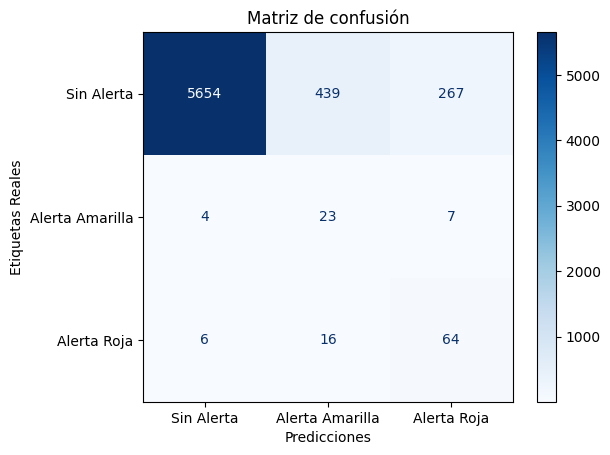

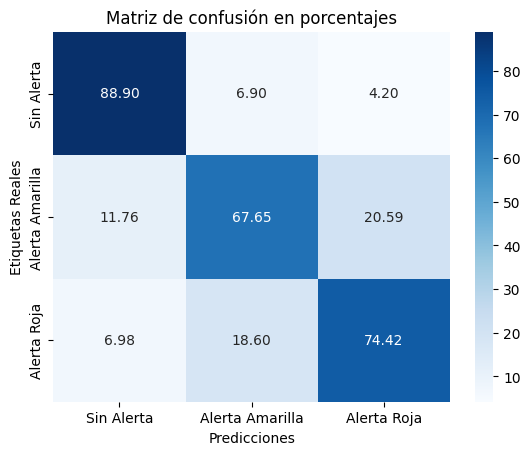

In [25]:
rf1 = RandomForestClassifier(**best_hyperparameters1["Random Forest"])

train_predict_evaluate(rf1, X_train=X1_train, y_train=y1_train, X_test=X1_test,
                       y_test=y1_test, display_labels=["Sin Alerta", "Alerta Amarilla", "Alerta Roja"])

#### Conclusión del experimento 1:
___

- **Clase 0 (Sin Alerta):** El modelo es extremadamente preciso (precisión de 1.00) y tiene un buen desempeño en identificar correctamente los casos que no requieren alerta (recall de 0.89). Que el modelo tenga una precisión tan alta indica que la gran mayoría de los registros que fueron identificados como 'Sin Alerta', efectivamente no requieren alerta. Esto es un resultado positivo, pues, se considera muy riesgoso que el modelo identifique un incendio como 'Sin Alerta' cuando en realidad requiere alerta. También hay que mencionar que el hecho de que está métrica sea tan alta puede deberse a la predominancia de esta clase en el conjunto de datos. Por lo que no se puede concluir que el modelo es muy bueno solo por esta métrica.
  
    Quizás para este modelo no es tan problemático tener un buen recall para esta clase, pues, no parece ser tan riesgoso que el modelo identifique un incendio como 'Alerta amarilla' o 'Alerta roja' cuando en realidad no lo es. De todos modos el recall de esta clase es bastante bueno (0.89).


- **Clase 1 (Alerta Amarilla):** La precisión es muy baja (0.05), indicando que la mayoría de las predicciones de 'Alerta amarilla' son incorrectas. Viendo la matriz de confusión se puede notar que la mayoría de los incendios que fueron identificados como 'Alerta amarilla' en realidad no requerían alerta, esto se puede deber al desbalance de clases. También hay bastantes incendios que fueron identificados como 'Alerta amarilla' pero que en realidad requerían 'Alerta roja', esto es un resultado negativo (de los incendios identificados como 'Alerta amarilla' 16 requerían 'Alerta roja' y 23 requerían 'Alerta Amarilla')

    Por otro lado, el modelo identifica correctamente el 68% de las verdaderas alertas amarillas (recall). Viendo la matriz de confusión se puede notar que de los incendios que requerían 'Alerta amarilla' solo el 11.8% fue identificado como 'Sin alerta', esto es un resultado positivo, pues, ya mencionamos que es riesgoso que el modelo identifique un incendio como 'Sin Alerta' cuando en realidad requiere alerta. Aunque no es tan riesgoso que el modelo identifique un incendio como 'Alerta roja' cuando en realidad requiere 'Alerta amarilla'.

- **Clase 2 (Alerta Roja):** La precisión de esta clase es baja (0.19), lo que indica que muchas de las predicciones de 'Alerta roja' hechas por el modelo son incorrectas, de hecho la mayoría de las predicciones de 'Alerta roja' son en realidad 'Sin alerta'. Al examinar la matriz de confusión, se observa que un número significativo de incendios identificados como 'Alerta roja' en realidad no lo requerían, siendo clasificados erróneamente en lugar de 'Sin Alerta' o 'Alerta Amarilla', aunque como se mencionó antes esto no supone un gran probema y en general puede estar influido por el desbalance de clases.

    Por otro lado, el modelo muestra un recall relativamente alto para esta clase (0.74), lo que significa que es capaz de identificar correctamente el 74% de los incendios que realmente requerían 'Alerta roja'. Al revisar la matriz de confusión, se puede notar que el 18.6% de los incendios que tenian 'Alerta roja' fueron clasificados erróneamente como 'Alerta amarilla' y el 7% como 'Sin alerta'.

- **Conclusiones generales:** En conclusión, este modelo no es eficiente si se busca predecir en una aplicación real las alertas provocadas por incendios. Si bien tiene un rendimiento suficiente para poder predecir los incendios 'Sin Alerta', esto se da porque la mayoría de datos son de esta categoría. Por otro lado, este modelo además comete errores que pueden tener grandes consecuencias, como puede ser el caso de predicciones de alerta roja, en donde un 7% aproximadamente es clasificado erróneamente como 'Sin Alerta', esto podría provocar que un incendio de gran magnitud que eventualmente podría ocasionar una catástrofe, pase desapercibido.

### Experimento 2
(Pregunta 2)

#### Selección de las columnas que se van a utilizar para predecir y la que se va a predecir:
___

Se seleccionan las columna siguiendo lo comentado en la propuesta metodológica.

In [26]:
X2 = df_mod.iloc[:, [6, 7, 8, 9, 11, 12, 13, 14,
                     15, 16, 17, 18, 19, 20, 21, 23]].to_numpy()

y2 = df_mod.iloc[:, 22].to_numpy()

#### Separación de los datos en entrenamiento y prueba:
___
Se separan los datos en entrenamiento y prueba, siguiendo lo comentado en la propuesta metodológica.

In [27]:
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=.3, random_state=42)

X2_train, y2_train = rus.fit_resample(X2_train, y2_train)

In [28]:
print(X2_train.shape)

(24722, 16)


#### Selección de los mejores hiperparámetros:
___

En esta sección se van a encontrar los mejores hiperparámetros para cada modelo, utilizando la función definida en el experimento 1.

In [29]:
best_hyperparameters2 = find_best_hyperparameters(
    models=models, param_grids=param_grid, X=X2_train, y=y2_train)

Buscando los mejores hiperparámetros para Decision Tree:


Mejores hiperparámetros para Decision Tree: {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 2}
Buscando los mejores hiperparámetros para K Nearest Neighbors:
Mejores hiperparámetros para K Nearest Neighbors: {'metric': 'manhattan', 'n_neighbors': 5}
Buscando los mejores hiperparámetros para Random Forest:
Mejores hiperparámetros para Random Forest: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Buscando los mejores hiperparámetros para Naive Bayes:
Mejores hiperparámetros para Naive Bayes: {}


#### Creación y evaluación de los modelos:
___

En esta sección se van a crear los modelos con los hiperparámetros encontrados antes. Además, se van a evaluar utilizando validación cruzada con 5 *folds* y se van a calcular las métricas *Accuracy*, *Precision*, *Recall* y *F1-score*.

In [30]:
models2 = models

best_hyperparameters2["Decision Tree"]["random_state"] = 42

models2["Decision Tree"] = DecisionTreeClassifier(
    **best_hyperparameters2["Decision Tree"])

models2["K Nearest Neighbors"] = KNeighborsClassifier(
    **best_hyperparameters2["K Nearest Neighbors"])

best_hyperparameters2["Random Forest"]["random_state"] = 42

models2["Random Forest"] = RandomForestClassifier(
    **best_hyperparameters2["Random Forest"])

models2["Naive Bayes"] = GaussianNB(**best_hyperparameters2["Naive Bayes"])

In [31]:
evaluate_and_print_metrics(models=models2, X=X2_train, y=y2_train)

Evaluating model: Decision Tree

Reporte de clasificación detallado:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71     12361
           1       0.71      0.70      0.71     12361

    accuracy                           0.71     24722
   macro avg       0.71      0.71      0.71     24722
weighted avg       0.71      0.71      0.71     24722

--------------------------------------------------
Evaluating model: K Nearest Neighbors

Reporte de clasificación detallado:
               precision    recall  f1-score   support

           0       0.61      0.61      0.61     12361
           1       0.61      0.60      0.61     12361

    accuracy                           0.61     24722
   macro avg       0.61      0.61      0.61     24722
weighted avg       0.61      0.61      0.61     24722

--------------------------------------------------
Evaluating model: Random Forest

Reporte de clasificación detallado:
               precision    r

Luego de correr los modelos, se puede observar que el mejor modelo es el de *Random Forest*, pues es superior en todas las métricas a los otros modelos. A excepción de *Naive Bayes* que es superior en *Recall* de la clase 0. Pero tiene un *Accuracy* muy bajo, y un *Recall* muy bajo en la clase 1. Por lo tanto, se continua con el modelo de *Random Forest*. Con los siguientes hiperparámetros:

- *max_depth:* 20
- *min_samples_leaf:* 2
- *min_samples_split:* 5
- *n_estimators*: 300

#### Evaluación del modelo final con los datos de prueba:
___

Ahora se va a evaluar el mejor modelo, con los datos de prueba. Se va a calcular las métricas *Accuracy*, *Precision*, *Recall* y *F1-score*. Además, se va a calcular la matriz de confusión.

              precision    recall  f1-score   support

           0       0.86      0.76      0.81     11867
           1       0.58      0.73      0.65      5379

    accuracy                           0.75     17246
   macro avg       0.72      0.75      0.73     17246
weighted avg       0.77      0.75      0.76     17246



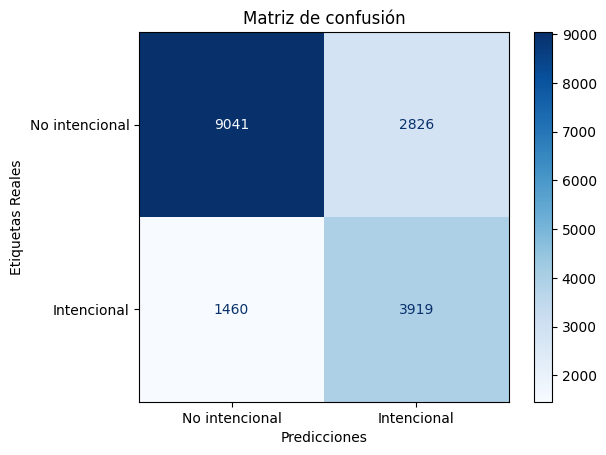

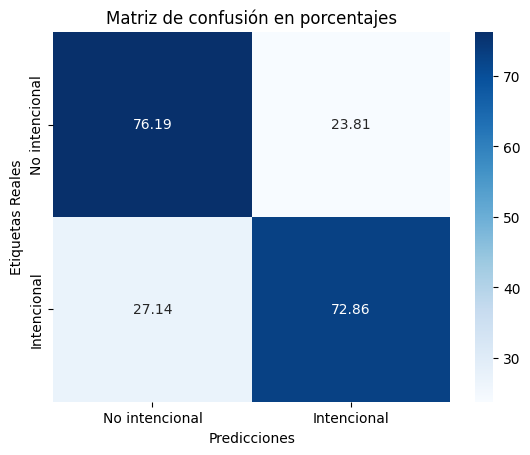

In [32]:
rf2 = RandomForestClassifier(**best_hyperparameters2["Random Forest"])

train_predict_evaluate(rf2, X_train=X2_train, y_train=y2_train, X_test=X2_test,
                       y_test=y2_test, display_labels=['No intencional', 'Intencional'])

#### Conclusión del experimento 2
---
Una vez realizado el experimento sí se pueden identificar ciertos patrones para diferenciar las causas entre intencionales y no intencionales, la precisión de la clase no intencional es relativamente alta (0.86), por lo que las instancias clasificadas como no intencionales, el 86% realmente lo son, pero la precisión en la clase intencional es mucho más baja, ya que es solo alcanza un (0.58), por lo que el 58% de las instancias que son intencionales, realmente lo son, este valor bastante bajo lo que indica deficiencias en el modelo al momento de detectar los casos intecionales. A su vez, la No Intencionalidad tiene un f1-score bastante alto (0.81) lo que es un buen indicio, significa que el modelo es bueno prediciendo esta categoría, pero veamos que tan bueno es observando la matriz de confusión.

Observando la matriz de confusión, se puede apreciar también que para incendios intencionales estos se logran predecir en aproximadamente un 73% de las ocasiones, mientras que para los incendios no ocasionales, estos se logran predecir el 76% de las ocasiones. Esto provoca que el modelo no tenga una alta precisión pues falla mucho en ciertos casos, lo que dificulta llevarlo a una aplicacion real donde se busque identificar la intencionalidad del modelo tan solo con los parámetros de este dataset.

- **Conclusiones generales:** En conclusión, aunque el modelo tiene un rendimiento aceptable en la identificación de estos patrones, la capacidad del modelo para poder predecir incendios intenciones tiene un gran margen de mejora. El modelo se podría ajustar de mejor manera si se complementara con datos meteorológicos, opinión de expertos, para saber que parámetros tienen mayor relevancia que otros, y con una mejor elección de los hiperparámetros o algoritmos a utilizar.

### Experimento 3

#### Preliminares
___
En está sección se van a seleccionar las columnas que se van a utilizar para generar los *clusters* y se van a normalizar los datos.

In [33]:
df_clustering = df_mod.iloc[
    :, [6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
]

In [34]:
df_clustering.dtypes

HoraInicio                         int32
DuracionMinutos                  float64
Alerta                             int64
Escenario                          int64
SuperficieQuemadaEucalipto       float64
SuperficieQuemadaOtrasPlantas    float64
SuperficieQuemadaArbolado        float64
SuperficieQuemadaMatorral        float64
SuperficieQuemadaPastizal        float64
SuperficieQuemadaAgricola        float64
SuperficieQuemadaDesechos        float64
SuperficieQuemadaTotal           float64
Latitud                          float64
Longitud                         float64
SuperficieQuemadaPino            float64
Intencional                        int32
Mes                                int32
dtype: object

Se puede notar que todos los datos que se van a utilizar son de tipo numérico.

Ahora se van a normalizar los datos:

In [35]:
no_show_warnings()

# Estandarizar los datos
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_clustering)

In [36]:
no_show_warnings()

# Normalizar los datos
df_clustering = normalize(scaled_df)

# Convertir a un DataFrame
df_clustering = pd.DataFrame(df_clustering)

In [37]:
df_clustering.head()

0         1         2         3         4         5         6   \
0  0.128702  0.481071 -0.054262 -0.208599 -0.017287 -0.008394 -0.011811   
1 -0.061702 -0.326142 -0.053663 -0.206297 -0.017096 -0.008301 -0.016276   
2  0.214571 -0.334539 -0.052128 -0.200396 -0.016607 -0.008064 -0.015811   
3  0.198999 -0.354666 -0.055437 -0.213116 -0.017661 -0.008576 -0.016814   
4 -0.065730 -0.361031 -0.052646 -0.202386 -0.016772 -0.008144 -0.015968   

         7         8         9         10        11        12        13  \
0 -0.018863 -0.013589 -0.007919 -0.024818 -0.018959  0.536647  0.169177   
1 -0.022982 -0.025642 -0.007832 -0.024544 -0.022918  0.559428  0.173015   
2 -0.021904 -0.025567 -0.007608 -0.023842 -0.022263  0.553197  0.141122   
3 -0.023742 -0.024389 -0.008091 -0.025356 -0.023336  0.482753  0.134155   
4 -0.022546 -0.025156 -0.007683 -0.024079 -0.022484  0.551724  0.185871   

         14        15        16  
0 -0.011081 -0.287833  0.551254  
1 -0.010959 -0.284657  0.646020  
2 -0.010645 -0.276514  0.627539  
3 -0.011321 -0.294066  0.667375  
4 -0.010751 -0.279260  0.633772

Ya están normalizados los datos, por lo que se pueden utilizar para generar los *Clusters*.

#### K-Means
___

En esta sección se va a generar los *clusters* utilizando el algoritmo *K-Means*.

Para comenzar se va a utilizar el método del codo para elegir la cantidad de *clusters* óptima.

In [38]:
def metodo_codo(num_clusters: list,
                row: int,
                column: int,
                plot_number: int,
                xline_1: int,
                xline_2: int,
                xline_3: int,
                X: np.ndarray) -> None:

    """Genera el gráfico para utilizar el método del codo"""
    inercias = []
    for i in num_clusters:
        modelo = KMeans(n_clusters=i, random_state=42)
        modelo.fit(X)
        inercias.append(modelo.inertia_)
    plt.subplot(row, column, plot_number)
    plt.plot(num_clusters, inercias, '-o')
    plt.axvline(x=xline_1, color='red', linestyle='--')
    plt.axvline(x=xline_2, color='green', linestyle='--')
    plt.axvline(x=xline_3, color='orange', linestyle='--')
    plt.title('Método del codo')
    plt.xlabel('N Clusters')
    plt.xticks(num_clusters)

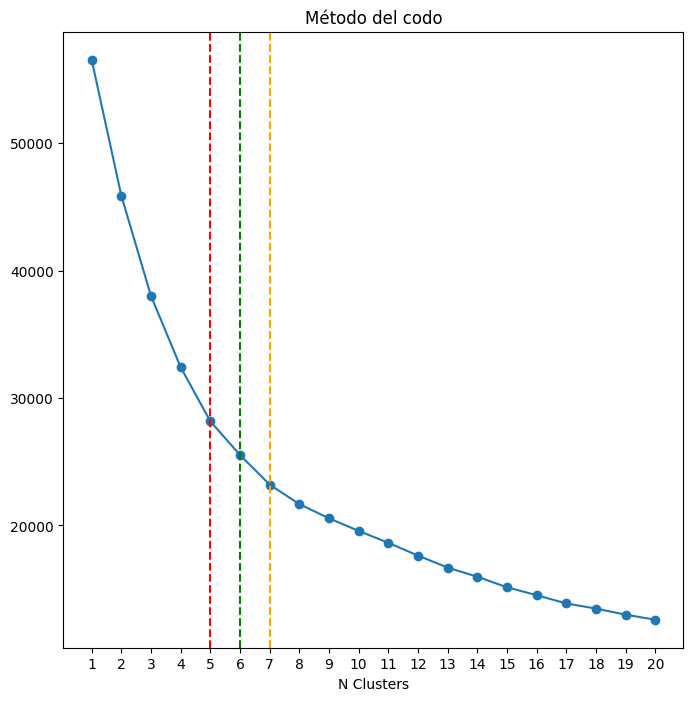

In [39]:
plt.figure(figsize=(8, 8))
metodo_codo(
    num_clusters=range(1, 21),
    row=1,
    column=1,
    plot_number=1,
    xline_1=5,
    xline_2=6,
    xline_3=7,
    X=df_clustering,
)
plt.show()

Se puede notar que el codo se produce entre $5$, $6$ y $7$ *Clusters*, por lo que se va a probar con todas esas cantidades de *Clusters*.

Ahora se van a generar los *Clusters* con $5$, $6$ y $7$ *Clusters*.

In [40]:
# Crear los modelos de K-Means
kmeans_5 = KMeans(n_clusters=5, n_init=10, max_iter=1000, random_state=42)
kmeans_5.fit(df_clustering)

kmeans_6 = KMeans(n_clusters=6, n_init=10, max_iter=1000, random_state=42)
kmeans_6.fit(df_clustering)

kmeans_7 = KMeans(n_clusters=7, n_init=10, max_iter=1000, random_state=42)
kmeans_7.fit(df_clustering)

KMeans(max_iter=1000, n_clusters=7, n_init=10, random_state=42)

#### DBSCAN
___

En esta sección se va a generar los *Clusters* utilizando el algoritmo *DBSCAN*.

Para comenzar se va a utilizar el método de la rodilla para elegir el valor de $\epsilon$ óptimo.

In [41]:
def metodo_rodilla(N: int,
                   yline: float,
                   row: int,
                   column: int,
                   plot_number: int,
                   X: np.ndarray) -> None:

    """Genera el gráfico para utilizar el método de la rodilla"""
    nbrs = NearestNeighbors(n_neighbors=N).fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:, N-1]
    plt.subplot(row, column, plot_number)
    plt.plot(distances)
    plt.axhline(y=yline, color='r', linestyle='--')
    plt.xlabel('Puntos del dataset ordenados')
    plt.ylabel('k-ésima distancia al vecino más cercano')

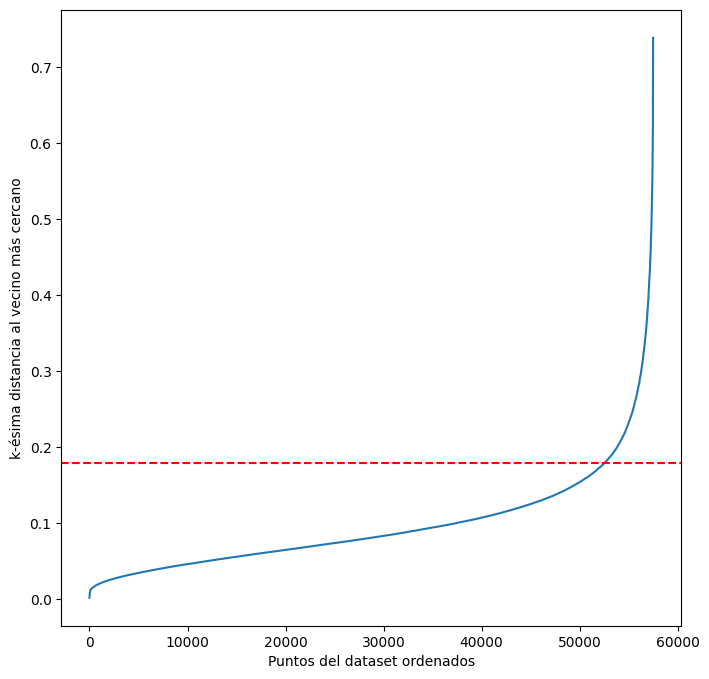

In [42]:
no_show_warnings()
plt.figure(figsize=(8, 8))
metodo_rodilla(N=3, yline=0.18, row=1, column=1, plot_number=1, X=df_clustering)
plt.show()

Se puede notar que el codo se produce aproximandamente en $0.18$ para $N=3$, por lo que se va a hacer *DBSCAN* con ese valor de $\epsilon$. Se eligió $N=3$ pues para la gran cantidad de datos es conveniente utilizar un $N$ pequeño.

A continuación se va a generar los *clusters* con $\epsilon=0.18$ y $N=3$:

In [43]:
# Crear modelo de DBSCAN
dbscan = DBSCAN(eps=0.18, min_samples=3)
dbscan.fit(df_clustering)

DBSCAN(eps=0.18, min_samples=3)

#### Gaussian Mixture Models
___

En esta sección se va a generar los *Clusters* utilizando el algoritmo *Gaussian Mixture Models*.

Se va a utilizar la misma cantidad de componentes que *Clusters* que se obtuvieron con el método del codo para *K-Means*. Por lo que se van a generar $5$, $6$ y $7$ *Clusters*.

In [44]:
# Crear GMM
gmm_5 = GaussianMixture(
    n_components=5,
    covariance_type="full",
    n_init=10,
    max_iter=100,
    tol=0.01,
    init_params="kmeans",
    random_state=42,
)
gmm_5.fit(df_clustering)
gmm_5_pred = gmm_5.predict(df_clustering)

gmm_6 = GaussianMixture(
    n_components=6,
    covariance_type="full",
    n_init=10,
    max_iter=100,
    tol=0.01,
    init_params="kmeans",
    random_state=42,
)
gmm_6.fit(df_clustering)
gmm_6_pred = gmm_6.predict(df_clustering)

gmm_7 = GaussianMixture(
    n_components=7,
    covariance_type="full",
    n_init=10,
    max_iter=100,
    tol=0.01,
    init_params="kmeans",
    random_state=42,
)
gmm_7.fit(df_clustering)
gmm_7_pred = gmm_7.predict(df_clustering)

#### Evaluación de los Clusters
___

En esta sección se va a evaluar los *Clusters* generados con los algoritmos *K-Means*, *DBSCAN* y *Gaussian Mixture Models*.

Para comenzar se va a realizar un reducción de dimensionalidad con *PCA*:

In [45]:
# PCA
pca = PCA(n_components=2, random_state=42).fit(df_clustering)
df_pca_clustering = pca.transform(df_clustering)

In [46]:
max_comps = 2
for i, evr in enumerate(pca.explained_variance_ratio_.cumsum()[:max_comps]):
    print(f"{i+1}: {evr*100:.4f}%")

1: 24.8920%
2: 45.0691%


Se puede notar que con las dos componentes de *PCA* solo se explica el  $45\%$ de la varianza, por lo que tenemos una pérdida de información importante.

A continuación se va a graficar los datos en un plano cartesiano:

Text(0.5, 1.0, 'Gráfico de los dato sin agrupar')

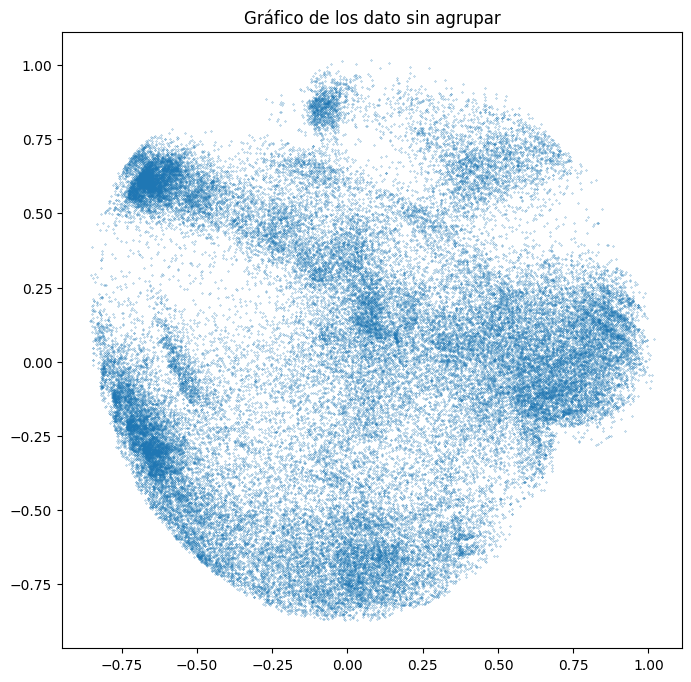

In [47]:
# Gráfico de los datos sin agrupar
plt.figure(figsize=(8, 8))
plt.scatter(df_pca_clustering[:, 0], df_pca_clustering[:, 1], s=0.05)
plt.title("Gráfico de los dato sin agrupar")

In [48]:
def plot_clusters(s: float,
                  title: str,
                  model,
                  row: int,
                  column: int,
                  plot_number: int,
                  X: np.ndarray,
                  centroids=False,
                  pca=pca) -> None:

    """Hace un subplot que muestra los cluster en un scatterplot"""
    plt.subplot(row, column, plot_number)
    plt.scatter(X[:, 0], X[:, 1], c=model.labels_, s=s)
    if centroids:
        centroids_pca = pca.transform(model.cluster_centers_)
        plt.scatter(centroids_pca[:, 0],
                    centroids_pca[:, 1], marker='*', s=100, c='r')
    plt.title(title)

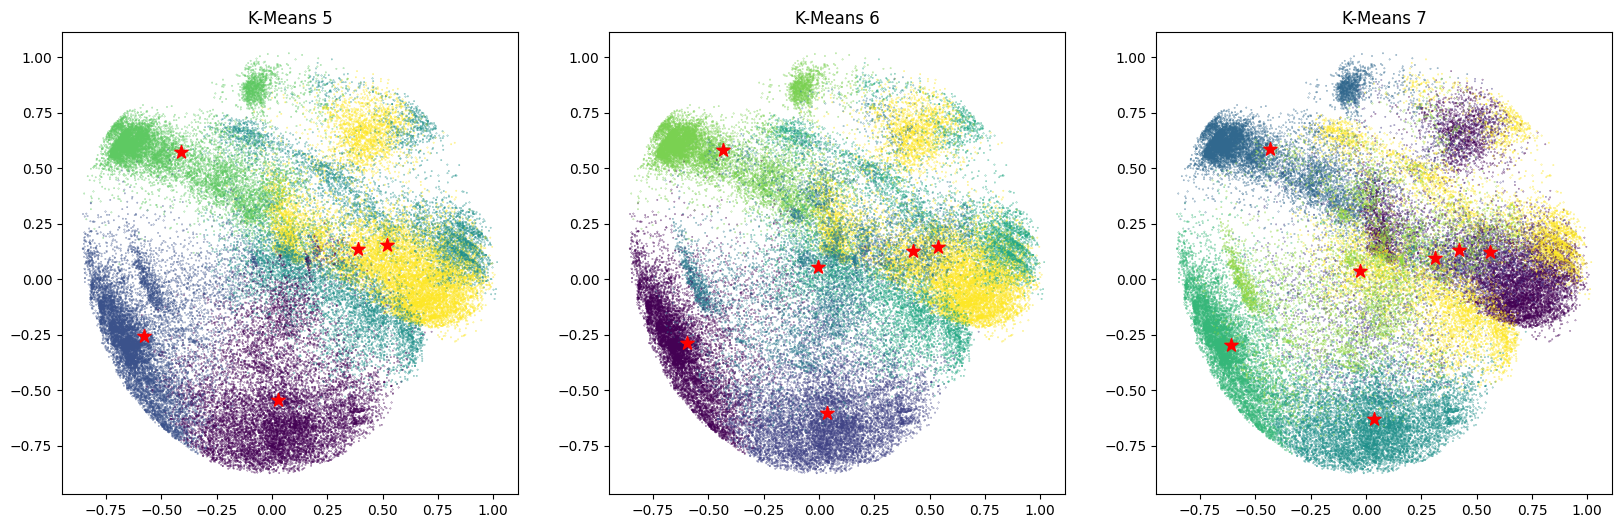

In [49]:
# KMeans
plt.figure(figsize=(20, 6))
plot_clusters(
    s=0.05,
    title="K-Means 5",
    model=kmeans_5,
    row=1,
    column=3,
    plot_number=1,
    X=df_pca_clustering,
    centroids=True,
)
plot_clusters(
    s=0.05,
    title="K-Means 6",
    model=kmeans_6,
    row=1,
    column=3,
    plot_number=2,
    X=df_pca_clustering,
    centroids=True,
)
plot_clusters(
    s=0.05,
    title="K-Means 7",
    model=kmeans_7,
    row=1,
    column=3,
    plot_number=3,
    X=df_pca_clustering,
    centroids=True,
)
plt.show()

Los *clusters* generados mediante el algoritmo *K-Means* exhiben una separación notablemente clara, demostrando la capacidad del algoritmo para distinguir eficientemente entre zonas de alta densidad. Este patrón sugiere que *K-Mean*s es particularmente competente en identificar y aislar estas áreas densas, tratándolas como *clusters* independientes.

Resulta interesante observar que esta tendencia se mantiene consistente en configuraciones del algoritmo que varían entre 5, 6 y 7 *clusters*. En cada una de estas configuraciones, se logra identificar zonas similares como pertenecientes a los mismos *clusters*. Este comportamiento refuerza la idea de que *K-Means* es efectivo no solo en la creación de divisiones claras, sino también en la identificación consistente de grupos similares a través de diferentes números de *clusters*.

También es importante notar que estos gráficos reducidos a dos dimensiones no son capaces de representar la totalidad de la información contenida en los datos. Por lo tanto, es posible que existan grupos que no se logren distinguir en este plano, pero que sí sean identificados por el algoritmo.

<function matplotlib.pyplot.show(close=None, block=None)>

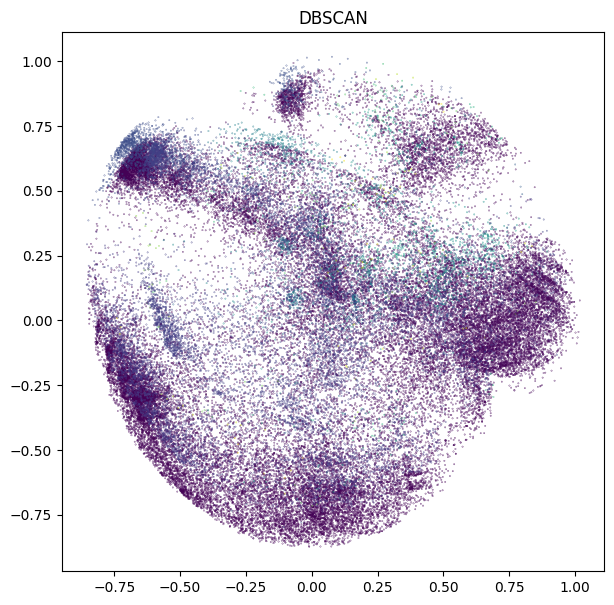

In [50]:
# DBSCAN
plt.figure(figsize=(7, 7))
plot_clusters(
    s=0.05,
    title="DBSCAN",
    model=dbscan,
    row=1,
    column=1,
    plot_number=1,
    X=df_pca_clustering,
)
plt.show

In [51]:
labs, counts = np.unique(dbscan.labels_, return_counts=True)
for i in range(0, len(labs)):
    print(f"{labs[i]}: {counts[i]}", end=" | ")

-1: 3899 | 0: 25409 | 1: 3119 | 2: 10559 | 3: 4 | 4: 4 | 5: 3 | 6: 5 | 7: 4 | 8: 108 | 9: 16 | 10: 8 | 11: 7 | 12: 8 | 13: 4 | 14: 3 | 15: 3 | 16: 4 | 17: 7 | 18: 5 | 19: 6 | 20: 7 | 21: 3 | 22: 4 | 23: 4 | 24: 3 | 25: 3 | 26: 5 | 27: 6 | 28: 3 | 29: 10 | 30: 3 | 31: 3282 | 32: 617 | 33: 4424 | 34: 706 | 35: 24 | 36: 180 | 37: 7 | 38: 3 | 39: 6 | 40: 5 | 41: 3 | 42: 1522 | 43: 195 | 44: 92 | 45: 472 | 46: 3 | 47: 3 | 48: 3 | 49: 3 | 50: 5 | 51: 5 | 52: 3 | 53: 3 | 54: 3 | 55: 3 | 56: 3 | 57: 3 | 58: 3 | 59: 3 | 60: 3 | 61: 3 | 62: 3 | 63: 3 | 64: 3 | 65: 3 | 66: 129 | 67: 3 | 68: 415 | 69: 4 | 70: 4 | 71: 3 | 72: 3 | 73: 4 | 74: 5 | 75: 5 | 76: 131 | 77: 6 | 78: 324 | 79: 4 | 80: 4 | 81: 4 | 82: 5 | 83: 88 | 84: 4 | 85: 3 | 86: 4 | 87: 4 | 88: 131 | 89: 4 | 90: 9 | 91: 20 | 92: 222 | 93: 353 | 94: 3 | 95: 6 | 96: 5 | 97: 4 | 98: 88 | 99: 71 | 100: 38 | 101: 5 | 102: 7 | 103: 7 | 104: 15 | 105: 19 | 106: 5 | 107: 80 | 108: 16 | 109: 4 | 110: 5 | 111: 4 | 112: 10 | 113: 10 | 114: 13 | 11

El algoritmo *DBSCAN* ha sido **descartado** para su uso en este análisis. La razón principal de esta decisión es su tendencia a clasificar la mayoría de los datos (un total de $25409$ puntos) en un único *cluster*, identificado como *'cluster 0'*. El tercer *cluster* más grande identificado por *DBSCAN* es el *'cluster -1'*, que representa los puntos de datos que no se asignaron a ningún *cluster* definido.

Gráficamente se puede observar que los *clusters* generados por *DBSCAN* no son capaces de distinguir entre las zonas de alta densidad, y en cambio, tienden a agruparlas en un único *cluster*.

Esta peculiaridad sugiere que *DBSCAN*, que se basa en la densidad de los datos para formar *clusters*, no es eficaz en este caso particular debido a la falta de separación clara entre los grupos de datos. La proximidad y distribución de los datos parece desafiar la capacidad del algoritmo para discriminar y formar *clusters* múltiples y bien definidos.

In [52]:
def plot_gmm(s: float,
             alpha: float,
             title: str,
             model,
             row: int,
             column: int,
             plot_number: int,
             X: np.ndarray):

    """Hacer un subplot que muestra un gmm en un scatterplot"""
    plt.subplot(row, column, plot_number)
    plt.scatter(X[:, 0], X[:, 1], c=model, s=s, alpha=alpha)
    plt.title(title)

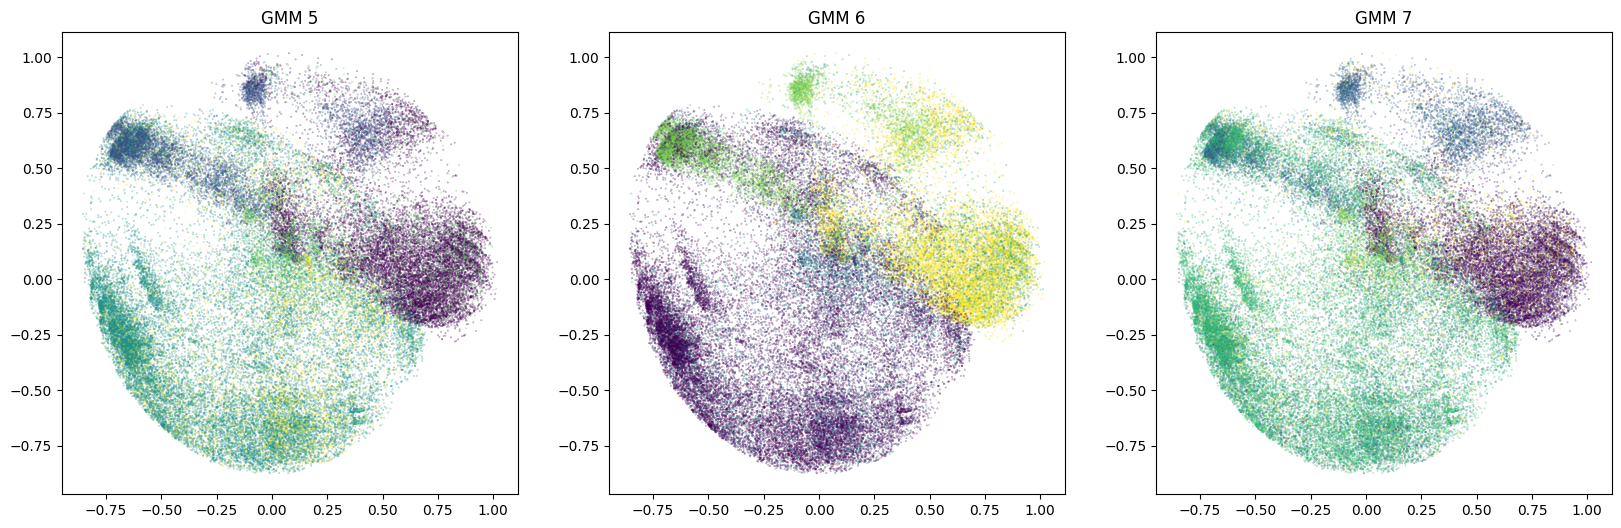

In [53]:
# GMM
plt.figure(figsize=(20, 6))
plot_gmm(
    s=0.1,
    alpha=0.5,
    title="GMM 5",
    model=gmm_5_pred,
    row=1,
    column=3,
    plot_number=1,
    X=df_pca_clustering,
)
plot_gmm(
    s=0.1,
    alpha=0.5,
    title="GMM 6",
    model=gmm_6_pred,
    row=1,
    column=3,
    plot_number=2,
    X=df_pca_clustering,
)
plot_gmm(
    s=0.1,
    alpha=0.5,
    title="GMM 7",
    model=gmm_7_pred,
    row=1,
    column=3,
    plot_number=3,
    X=df_pca_clustering,
)
plt.show()

Los modelos desarrollados utilizando *Gaussian Mixture Models (GMM)* han mostrado limitaciones en la identificación efectiva de *clusters*. Se observa que los clusters formados son excesivamente extensos y carecen de la precisión necesaria para delinear grupos específicos dentro del conjunto de datos. Esta característica sugiere que el *GMM* puede no ser el método más adecuado para abordar las particularidades de este problema específico. De todos modos vamos a evaluar los *clusters* generados por *GMM* con la matriz de proximidad.

El mejor de estos modelos es el que utiliza $5$ *clusters*. Se puede apreciar que separa tres grupos de datos, pero aún así, no logra agrupar los datos de forma clara.

Tras la comparación de los diferentes algoritmos de *clustering*, se ha decidido focalizar el análisis subsiguiente exclusivamente en los *clusters* generados por el algoritmo *K-Means* y el algoritmo *GMM*. Esta decisión se basa en la observación preliminar de que *K-Means* y *GMM* hba demostrado ser más eficaces en la formación de clusters bien definidos. Por lo tanto, se procederá a un examen más detallado de estos **clusters*.

Ahora se va a estudiar la matriz de proximidad de los modelos generados por KMeans:

In [54]:
def proximity_matrix(model_labels,
                     title: str,
                     row: int,
                     column: int,
                     plot_number: int,
                     frac: float,
                     X: np.ndarray) -> None:

    """Hacer un subplot que muestra una matriz de proximidad de los clusters"""
    row_num = int(X.shape[0] * frac)
    row_indices = np.random.choice(X.shape[0], row_num, replace=False)
    df_sample = X[row_indices, :]
    labels_sample = model_labels[row_indices]
    index = np.argsort(labels_sample)
    dist = euclidean_distances(df_sample[index], df_sample[index])
    plt.subplot(row, column, plot_number)
    plt.imshow(dist, cmap='jet')
    plt.title(title)
    plt.colorbar()

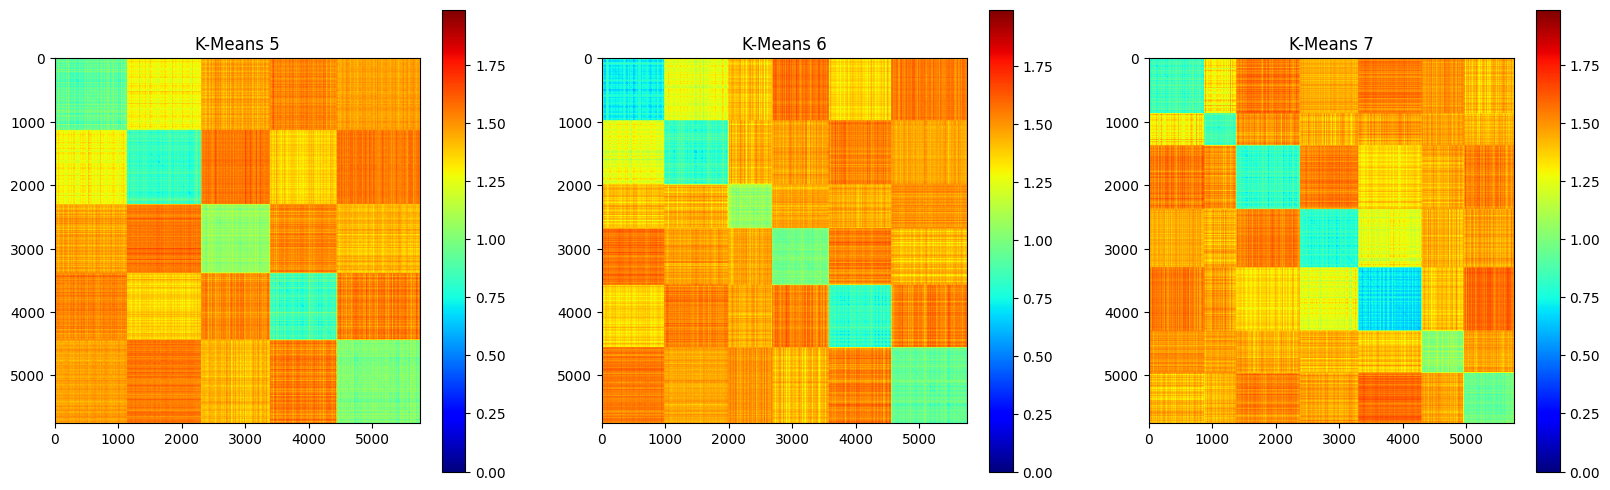

In [55]:
plt.figure(figsize=(20, 6))
proximity_matrix(
    model_labels=kmeans_5.labels_,
    title="K-Means 5",
    row=1,
    column=3,
    plot_number=1,
    frac=0.1,
    X=df_clustering.to_numpy(),
)
proximity_matrix(
    model_labels=kmeans_6.labels_,
    title="K-Means 6",
    row=1,
    column=3,
    plot_number=2,
    frac=0.1,
    X=df_clustering.to_numpy(),
)
proximity_matrix(
    model_labels=kmeans_7.labels_,
    title="K-Means 7",
    row=1,
    column=3,
    plot_number=3,
    frac=0.1,
    X=df_clustering.to_numpy(),
)
plt.show()

Se puede notar que los *clusters* generados por *K-Means* se ven bastante bien separados, en cada uno de los casos. También hay que notar que en los cálculos no se utilizaron los datos con *PCA*, por lo que, los cálculos son precisos.

En particular, en *K-Means 7* se puede ver que el tercer *cluster* (*cluster* 2) está proximo al *cluster* 4, algo similar ocurre con los *clusters* 2 y 3 de *K-Means 6*.

En general en todos los tres modelos todos los *clusters* diferentes están bastante separados. Aunque los elementos de un mismo *cluster* no están tan cercanos entre sí, pero lo suficiente para que se pueda considerar que son un *cluster*.

Ahora se muestra la matriz de proximidad de los modelos generados por GMM:

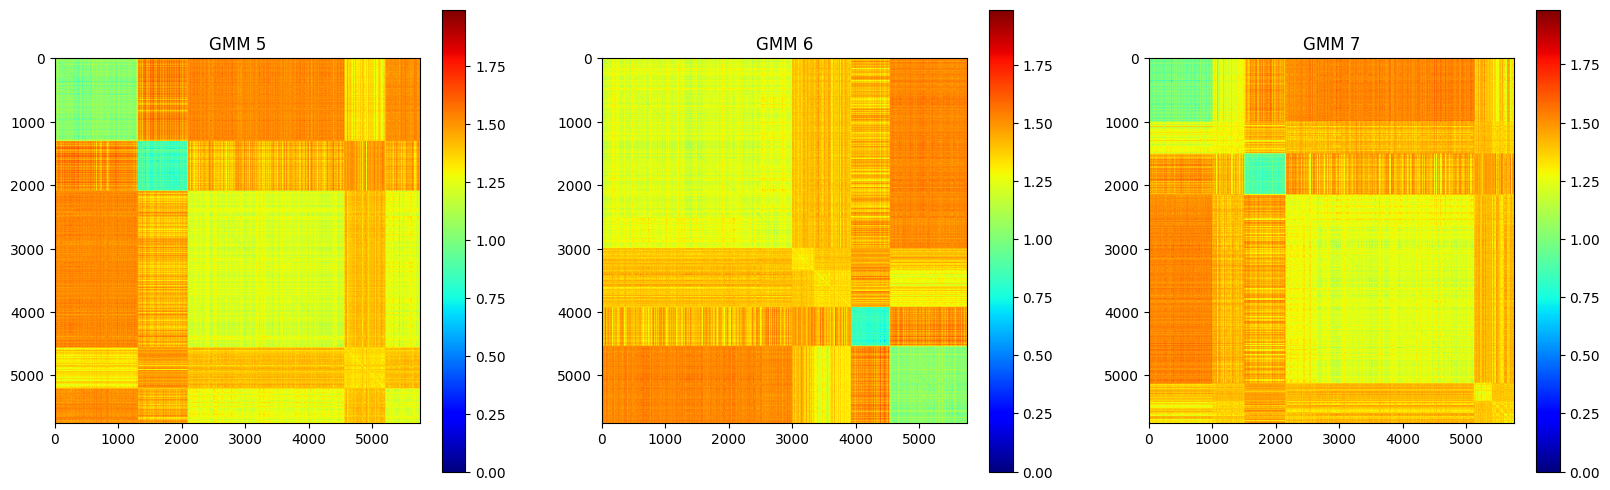

In [56]:
plt.figure(figsize=(20, 6))
proximity_matrix(
    model_labels=gmm_5_pred,
    title="GMM 5",
    row=1,
    column=3,
    plot_number=1,
    frac=0.1,
    X=df_clustering.to_numpy(),
)
proximity_matrix(
    model_labels=gmm_6_pred,
    title="GMM 6",
    row=1,
    column=3,
    plot_number=2,
    frac=0.1,
    X=df_clustering.to_numpy(),
)
proximity_matrix(
    model_labels=gmm_7_pred,
    title="GMM 7",
    row=1,
    column=3,
    plot_number=3,
    frac=0.1,
    X=df_clustering.to_numpy(),
)
plt.show()

Se puede notar que los *clusters* generados por *GMM* no están tan bien separados como los de *K-Means*. En todos los casos se puede ver clusters que están muy separados, pero que se consideran parte del mismo *cluster*. Además, hay *clusters* que están muy cercanos entre sí, pero que se consideran *clusters* diferentes (*GMM 7*). Por lo que, se va a descartar el uso de *GMM* para este análisis y se va a continuar con *K-Means*.

Ahora para concluir con la evaluación de los *clusters* se van a utilizar las métricas *Silhouette Score*, *Cohesión* y *Separación* para medir los modelos de *K-Means*:

In [57]:
def calculate_clustering_metrics(model,
                                 df: pd.DataFrame,
                                 whit_centroids=True) -> dict:

    """Calcula las métricas de un modelos de clustering"""
    metrics = {"silhouette": 0,
               "cohesion": None,
               "separation": None}
    labels = model.labels_
    metrics["silhouette"] = silhouette_score(df, labels)
    if whit_centroids:
        metrics["cohesion"] = 0
        metrics["separation"] = 0
        centroids = []
        label_set = set(labels)
        for label in label_set:
            cluster_points = df[labels == label]
            centroid = np.mean(cluster_points, axis=0)
            centroids.append(centroid)
            metrics["cohesion"] += np.sum(
                pairwise_distances(cluster_points, [centroid]))
        for i, centroid_i in enumerate(centroids):
            for j, centroid_j in enumerate(centroids):
                if i != j:
                    metrics["separation"] += np.linalg.norm(
                        centroid_i - centroid_j)
        metrics["separation"] /= len(centroids) * (len(centroids) - 1)
    return metrics

In [58]:
kmeans_5_metrics = calculate_clustering_metrics(kmeans_5, df=df_clustering)
print("K-Means 5:")
for key, value in kmeans_5_metrics.items():
    print(f"{key}: {value}")

K-Means 5:
silhouette: 0.26411269833530554
cohesion: 38593.18225438631
separation: 1.1081404565914172


In [59]:
kmeans_6_metrics = calculate_clustering_metrics(kmeans_6, df=df_clustering)
print("K-Means 6:")
for key, value in kmeans_6_metrics.items():
    print(f"{key}: {value}")

K-Means 6:
silhouette: 0.2743034757317911
cohesion: 36585.647342330965
separation: 1.1265721192062734


In [60]:
kmeans_7_metrics = calculate_clustering_metrics(kmeans_7, df=df_clustering)
print("K-Means 7:")
for key, value in kmeans_7_metrics.items():
    print(f"{key}: {value}")

K-Means 7:
silhouette: 0.28268358322402
cohesion: 34776.57832084246
separation: 1.153026973871238


**Silhouette Score:** Mide qué tan similar es un objeto a su propio *cluster* comparado con otros *clusters*. Los valores van de $-1$ a $1$, donde un valor alto indica que los objetos están bien emparejados a su propio cluster y mal emparejados a los vecinos.

- **K-Means 5:** $0.264$

- **K-Means 6:** $0.274$

- **K-Means 7:** $0.283$

Los tres modelos tienen valores de Silhouette positivos, lo cual es bueno. *K-Means 7* tiene el valor más alto, indicando que, en promedio, sus *clusters* están mejor definidos que los de los otros modelos. También hay que notar que los valores no son tan cercanos a $1$, lo que indica que en general los *clusters* no están bien definidos.

___

**Cohesion:** Mide la cercanía de los datos dentro del mismo *cluster*. Un valor más bajo es mejor, ya que indica que los puntos dentro de un *cluster* están más cerca entre sí.

- **K-Means 5:** $38593$
  
- **K-Means 6:** $36586$
  
- **K-Means 7:** $34777$
  
El **K-Means 7:** presenta la mejor cohesión, seguido por el **K-Means 6:** y luego el **K-Means 5:**. Esto sugiere que el **K-Means 7:** tiene clusters más densamente agrupados. En general, la cohesión de los modelos es similar entre todos los modelos.

___

**Separación:** Mide la distancia entre los *clusters*. Un valor más alto es mejor, indicando que los *clusters* están más separados entre sí.

- **K-Means 5:** $1.108$

- **K-Means 6:** $1.127$

- **K-Means 7:** $1.153$

*K-means 7* tiene la mayor separación, seguido por *K-Means 6* y luego *K-Means 5*. Esto sugiere que *K-Means 7* es el mejor en términos de separar los *clusters*. En general como se puede ver en los gráficos, los *clusters* no están muy separados, por lo que es natural que los valores de separación no sean muy altos.

___

Es natural que *K-Means 7* tenga la mejor separación y cohesión, pues, tiene más *Clusters* que los otros modelos.

**Conclusión:** El modelo que mejor parece ajustarse a los datos es *K-Means 7*, pues, tiene un buen valor de silhouette score, una buena separación y una buena cohesión. Además, como se puede ver en la matriz de proximidad, los *clusters* están bien definidos y separados. (En comparación con *K-Means 5* y *K-Means 6*). Por lo tanto, para analizar los *clusters* se va a utilizar el modelo *K-Means 7*.

### Análisis de los Clusters y Conclusión del experimento 3:

___

En esta sección se van a analizar las características los *Clusters* generados por *K-Means 7*.
Primero creamos un nuevo Data Frame con los datos de los *Clusters*:

In [61]:
df_with_clusters = df_mod
df_with_clusters.head()

Region    Provincia         Comuna  Temporada              Nombre  \
86   Valparaíso   Valparaíso     Casablanca  2002-2003           LO OROZCO   
88   Valparaíso  Marga Marga        Quilpué  2002-2003        ESTERO VIEJO   
91   Valparaíso   Valparaíso   Viña del Mar  2002-2003          GRANADILLA   
95   Valparaíso  San Antonio    San Antonio  2002-2003  QUEBRADA HUALLIPEN   
100  Valparaíso  Marga Marga  Villa Alemana  2002-2003   FORESTA EL CARMEN   

         Fecha  HoraInicio  DuracionMinutos  Alerta  Escenario  ...  \
86  2002-10-20         985            815.0       0          0  ...   
88  2002-11-03         878             68.0       0          0  ...   
91  2002-11-03        1038             51.0       0          0  ...   
95  2002-11-03        1022             52.0       0          0  ...   
100 2002-11-07         875             29.0       0          0  ...   

    SuperficieQuemadaMatorral  SuperficieQuemadaPastizal  \
86                        1.0                        2.0   
88                        0.0                        0.2   
91                        0.1                        0.1   
95                        0.0                        0.5   
100                       0.0                        0.2   

     SuperficieQuemadaAgricola  SuperficieQuemadaDesechos  \
86                         0.0                        0.0   
88                         0.0                        0.0   
91                         0.0                        0.0   
95                         0.0                        0.0   
100                        0.0                        0.0   

     SuperficieQuemadaTotal    Latitud   Longitud  SuperficieQuemadaPino  \
86                      4.0 -33.221667 -71.430556                    0.0   
88                      0.2 -33.060000 -71.404444                    0.0   
91                      0.2 -33.003333 -71.531389                    0.0   
95                      0.5 -33.578889 -71.601944                    0.0   
100                     0.2 -33.043333 -71.329167                    0.0   

     Intencional  Mes  
86             0   10  
88             0   11  
91             0   11  
95             0   11  
100            0   11  

[5 rows x 24 columns]

In [62]:
df_with_clusters["Cluster"] = kmeans_7.labels_
df_with_clusters.tail()

Region   Provincia     Comuna  Temporada  \
109977  Arica y Parinacota       Arica  Camarones  2019-2020   
109978  Arica y Parinacota       Arica      Arica  2019-2020   
109979  Arica y Parinacota       Arica      Arica  2019-2020   
109983  Arica y Parinacota  Parinacota      Putre  2019-2020   
109984  Arica y Parinacota       Arica  Camarones  2019-2020   

                              Nombre      Fecha  HoraInicio  DuracionMinutos  \
109977                     GUATANAVE 2019-07-04         930           1192.0   
109978                LA PONDEROSA I 2019-08-10         797            379.0   
109979               LA PONDEROSA II 2019-08-12         571            194.0   
109983  RESERVA NACIONAL LAS VICUÑAS 2019-12-10         900           1248.0   
109984                   CAMARONES 1 2020-05-15         616            314.0   

        Alerta  Escenario  ... SuperficieQuemadaPastizal  \
109977       0          0  ...                      0.19   
109978       0          0  ...                      2.00   
109979       0          0  ...                      0.60   
109983       0          0  ...                      0.50   
109984       0          0  ...                     18.00   

        SuperficieQuemadaAgricola  SuperficieQuemadaDesechos  \
109977                        0.0                        0.0   
109978                        0.0                        0.0   
109979                        0.0                        0.0   
109983                        0.0                        0.0   
109984                        0.0                        0.0   

        SuperficieQuemadaTotal    Latitud   Longitud  SuperficieQuemadaPino  \
109977                     0.5 -18.823611 -69.723611                    0.0   
109978                     2.6 -18.420556 -70.317778                    0.0   
109979                     0.6 -18.418056 -70.315556                    0.0   
109983                     0.5 -18.855278 -69.162222                    0.0   
109984                    18.0 -19.004167 -69.853333                    0.0   

        Intencional  Mes  Cluster  
109977            0    7        4  
109978            1    8        4  
109979            1    8        4  
109983            0   12        2  
109984            0    5        4  

[5 rows x 25 columns]

In [63]:
df_with_clusters["Cluster"].value_counts()

Cluster
2    9870
4    9636
3    9329
0    8801
6    8562
5    6410
1    4878
Name: count, dtype: int64

In [64]:
def cluster_metric(var: str,
                   df: pd.DataFrame,
                   operation,
                   cluster: int) -> float:
    result = operation((df[df["Cluster"] == cluster][var]))
    return result

In [65]:
def plot_cluster_histogram(
    var: str,
    df: pd.DataFrame,
    cluster: int,
    row: int,
    column: int,
    plot_number: int,
    bins: int = 10) -> None:
    """Crea un subplot que muestra un histograma para una variable y un cluster específicos."""
    data = df[df["Cluster"] == cluster][var]
    plt.subplot(row, column, plot_number)
    plt.hist(data, bins=bins, edgecolor="black")
    plt.title(f"Cluster {cluster} - {var}")
    plt.xlabel(var)
    plt.ylabel("Frecuencia")

In [66]:
var_list = [
    "DuracionMinutos",
    "SuperficieQuemadaTotal",
    "Latitud",
    "Intencional",
    "Mes",
]
op_dict = {"Mean": np.mean, "Median": np.median, "Max": np.max, "Min": np.min, "Std": np.std}
num_clusters = 7
for var in var_list:
    print(f"Resultados para la variable: {var}")
    columns = ["Cluster"] + list(op_dict.keys())
    results_var = pd.DataFrame(columns=columns)
    for cluster in range(num_clusters):
        row_data = {"Cluster": cluster}
        for op_name, op_func in op_dict.items():
            result = cluster_metric(var, df_with_clusters, op_func, cluster)
            row_data[op_name] = round(result, 3)
        new_row = pd.DataFrame([row_data])
        results_var = pd.concat([results_var, new_row], ignore_index=True)
    print(results_var.to_string(index=False))
    print("\n")

Resultados para la variable: DuracionMinutos
Cluster     Mean  Median    Max   Min     Std
      0  226.451   177.0  860.0  15.0 170.207
      1  469.351   419.0 1436.0  16.0 313.897
      2  174.843   133.0 1429.0  15.0 150.003
      3  180.071   142.0 1150.0  15.0 124.362
      4  153.769   132.0 1386.0  15.0  91.293
      5  349.280   197.0 1439.0  15.0 354.204
      6 1163.897  1187.0 1439.0 455.0 180.247


Resultados para la variable: SuperficieQuemadaTotal
Cluster    Mean  Median      Max  Min      Std
      0   7.638    0.76  2826.00  0.2   55.326
      1   9.736    1.02  1733.00  0.2   52.990
      2   6.739    1.00  2248.00  0.2   52.353
      3   5.101    0.85  1068.58  0.2   30.270
      4   6.463    1.00   800.00  0.2   33.824
      5 112.793    1.50 46490.00  0.2 1144.290
      6  23.167    2.20  4210.25  0.2  122.660


Resultados para la variable: Latitud
Cluster    Mean  Median     Max     Min   Std
      0 -36.976 -37.572 -27.121 -45.584 1.721
      1 -37.110 -37.497 -2

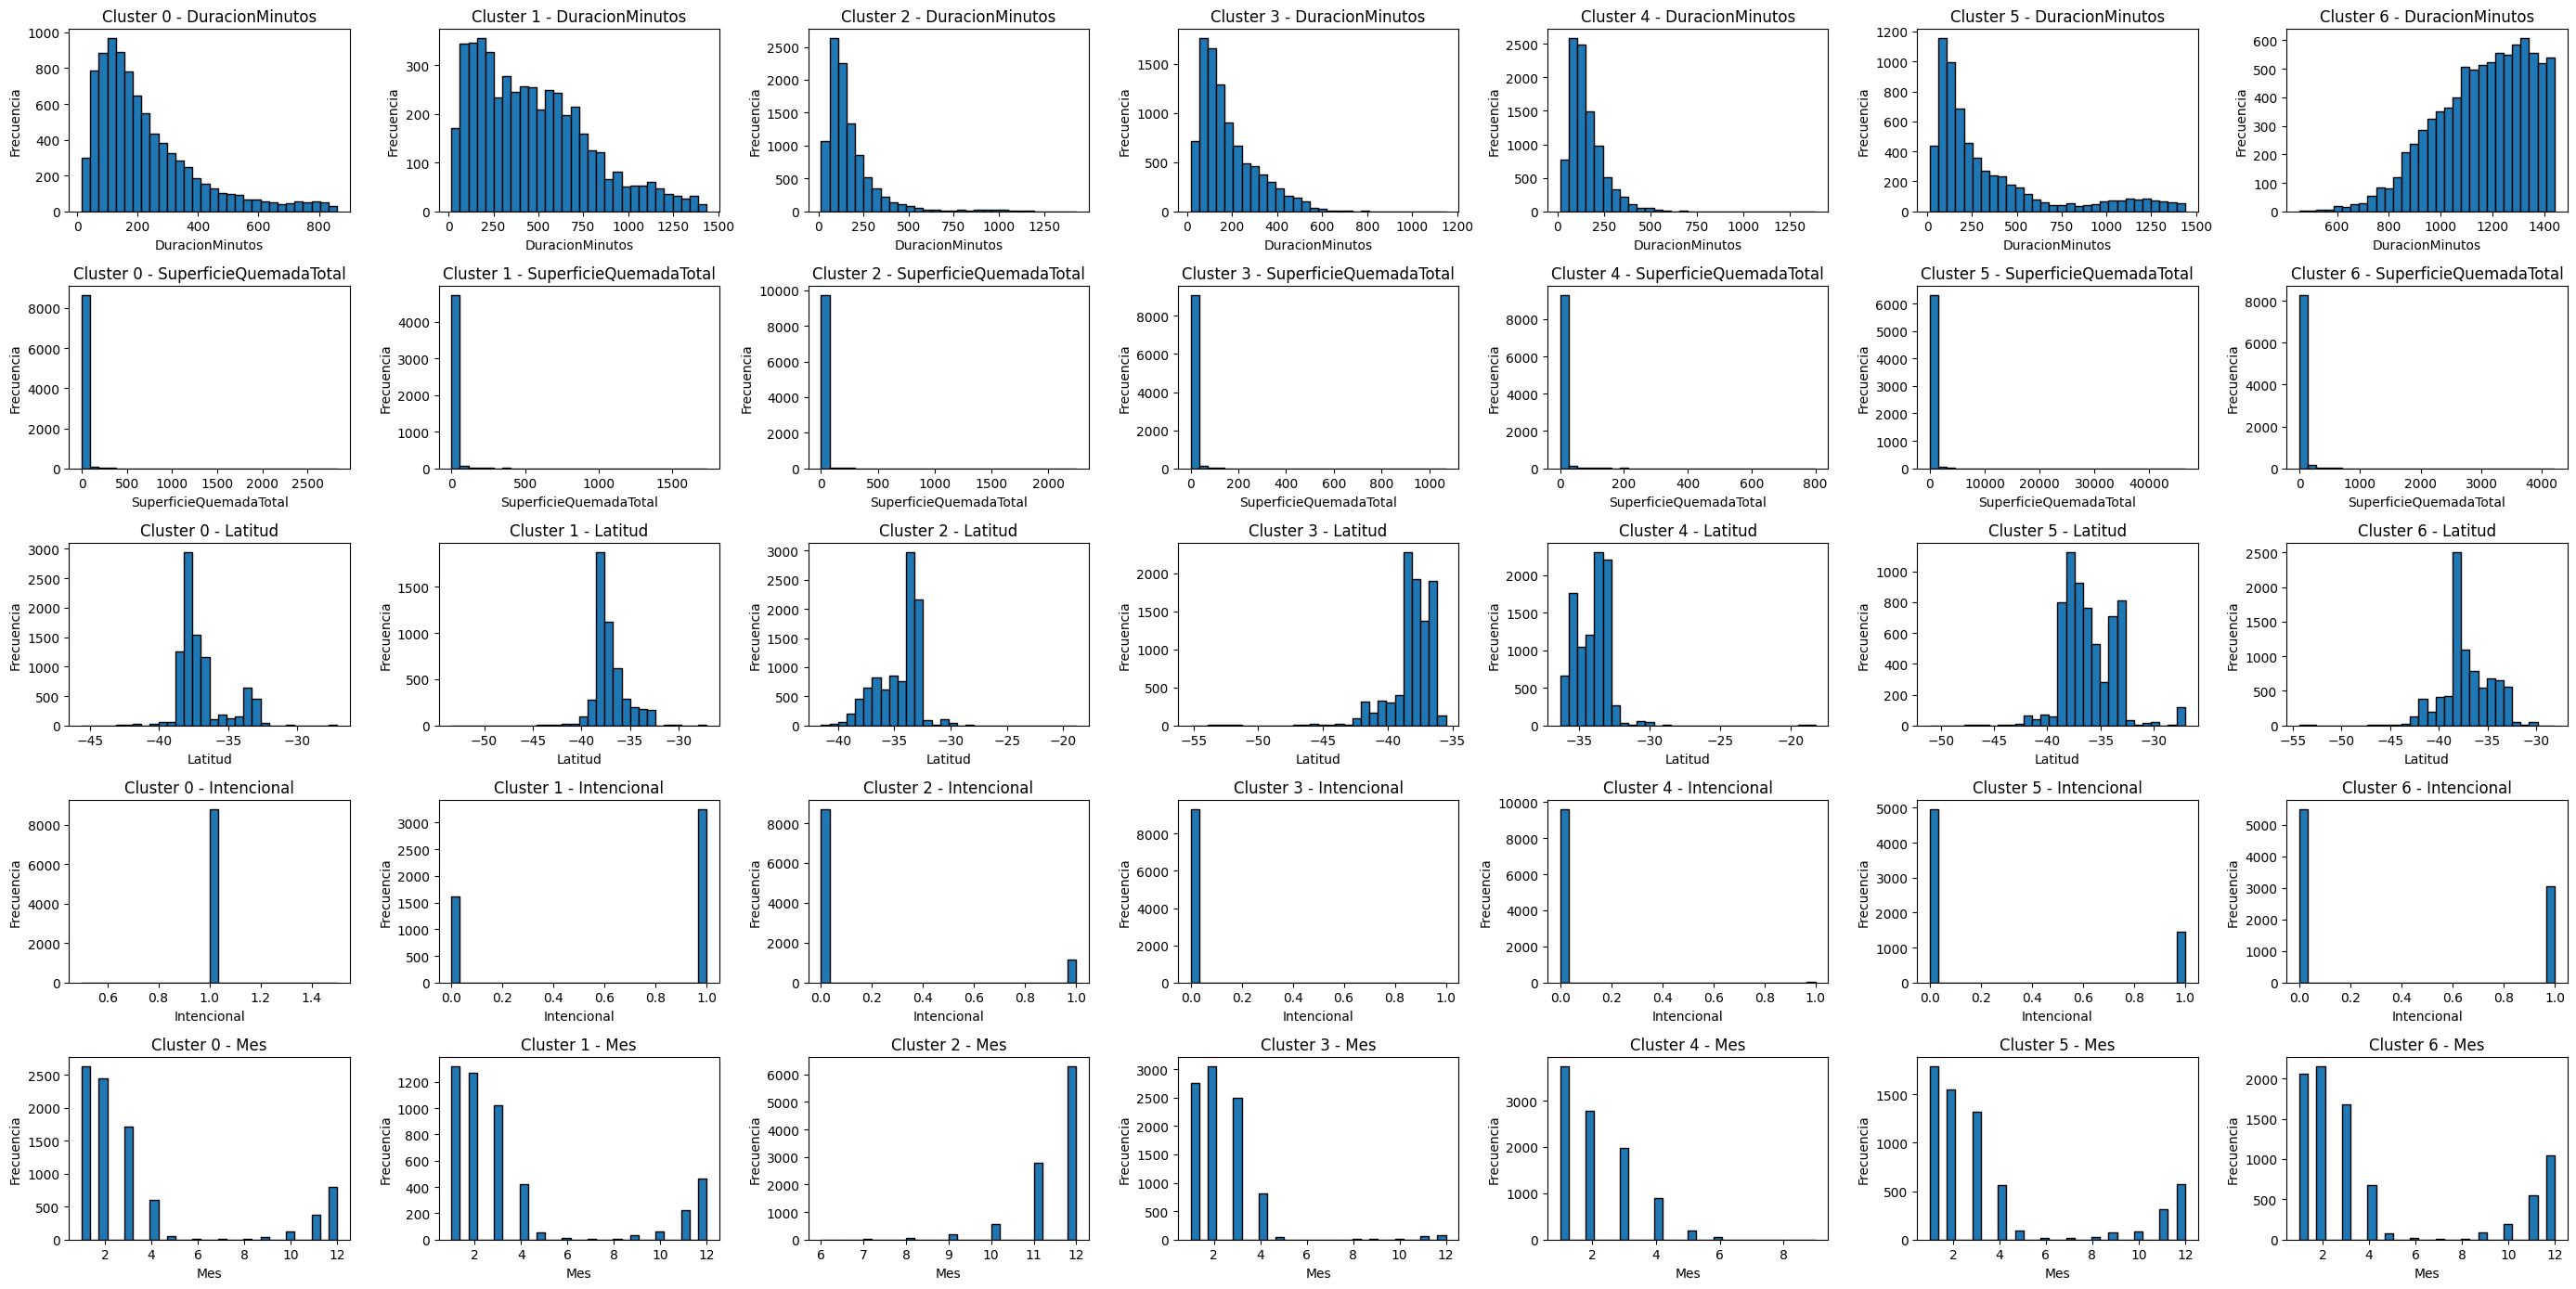

In [67]:
plt.figure(figsize=(28, 14))
total_plots = len(var_list) * num_clusters
plot_number = 1
for var in var_list:
    for cluster in range(num_clusters):
        plot_cluster_histogram(
            var,
            df_with_clusters,
            cluster,
            row=len(var_list),
            column=num_clusters,
            plot_number=plot_number,
            bins=30,
        )
        plot_number += 1
plt.tight_layout()
plt.show()

En cuanto a los resultados que fueron arrojados por el algoritmo de clustering se pueden desprender los siguientes hallazgos.

1. **DuracionMinutos:** El *cluster* 4 agrupó solo incendios de larga duración. Con una duración significativamente mayor a los otros *clusters*.

2. **SuperficieQuemada:** El *cluster* 5 agrupó todos los incendios con alta cantidad de superficie quemada, promediando desde 10 hasta aproximadamente 50 veces más que el resto de *clusters*.

3. **Latitud:** Se puede apreciar que el *cluster* 0 logró agrupar incendios desde Talca(-36°) hacia el Norte. En general no hay grandes diferencias en está característica.

4. **Intencional:** El primer cluster posee solo incendios intencionales. Por lo que logró agrupar eficientemente de acuerdo a esta categoría. Además, el sexto *cluster* posee un 67% de incendios Intencionales. Por otro lado, el *cluster* 0 y 3 poseen en su mayoría incendios no intencionales.

5. **Mes:** Se puede apreciar que para esta variable el segundo *cluster* agrupa solo incendios ocurridos en la segunda mitad del año, es decir desde Junio hacia adelante, agrupando en su mayoría incendios en Noviembre-Diciembre.

Este tipo de hallazgos también pueden juntarse, por ejemplo para el *cluster* 0 vemos que la mayoría de incendios son no intencionales, están ubicados desde aproximadamente Talca hacia el Norte y poseen una duración promedio de 153 minutos.

Podemos apreciar que para el primer *cluster* los incendios se ubican en promedio a mediados de marzo, son todos intencionales, duran en promedio 3 horas con 46 minutos quemando y queman en promedio 7.62 hectáreas.

- **Conclusión general:** En conclusión, este proceso de agrupamiento de alguna forma permite identificar ciertos patrones o característica en grupos de incendios, de acuerdo a causalidad, duración en minutos, mes, etc.

## Conclusiones finales del proyecto
___
Este proyecto entrega varios resultados importantes, a continuación se destacan los aspectos más relevantes:

El modelo desarrollado en el primer experimento no logró alcanzar la robustez necesaria para predecir la severidad de un incendio en curso de manera efectiva. Esto subraya la complejidad inherente al modelado de fenómenos naturales como los incendios y la necesidad de enfoques más sofisticados o datos adicionales para mejorar la precisión predictiva.

El segundo experimento reveló que, con las variables actuales, es difícil determinar la intencionalidad de un incendio. Pues, no es lo suficientemente preciso. Esto indica que para estudiar la intencionalidad de un incendio pueden llegar a hacer falta otras variables y para esto se podría consultar con conocimiento experto.

Una de las conclusiones más interesantes proviene del tercer experimento, donde se identificaron siete grupos distintos de incendios con características únicas. Este descubrimiento abre la puerta a futuras investigaciones que podrían incluir más datos y variables, lo que potencialmente podría llevar al descubrimiento de más categorías de incendios.

Hay muchas posibilidades de análisis, tal como se demostró durante el análisis exploratorio de datos. Se puede decir que el estudio de los incendios en Chile es un campo sumamente complicado. Durante este proyecto solo se estudió una pequeña parte dentro del gran espectro de posibilidades.

Es evidente que el estudio de los incendios tiene un impacto social profundo. Dada la relevancia de este tema, es importante seguir investigado y comprendiendo estos fenómenos desde varias perspectivas.

## Planificación futura
___

Este proyecto tiene muchas aristas y detalles que se podrían tratar en un trabajo futuro. Algunas de las cosas que se podrían hacer son:

1. **Integración de Variables Meteorológicas:** Este proyecto se beneficiaría enormemente con la integración de variables meteorológicas. Que es un factor sumamente importante en el desarrollo de los incendios. Estos datos se podrían obtener consultando fuentes públicas, pero su integración con los datos de los incendios no es sencilla.

2. **Análisis Detallado de Clusters:** Un ánalisis detallado de los *clusters* identificados en el experimento tres puede revelar patrones y características únicas asociadas con diferentes tipos de incendios. Este análisis podría encontrar información importante para combatir y comprender los incendios.

3. **Análisis e Interpretación de los Modelos:** Para comprender mejor como funcionan los modelos mostrados en este problema se puede hacer un análisis e interpretación de su funcionamiento, esto es fundamental en el caso de querer poner en producción los modelos.

4. **Aplicación de Redes Neuronales:** La implementación de técnicas de aprendizaje profundo podría ser un avance importante en este proyecto. Estas tecnologías pueden manejar volúmenes de datos más grandes, por lo que podrían ser efectivas para responder las preguntas en el caso de la incorporación de una mayor cantidad de datos. Las redes neuronales son capaces de encontrar relaciones no lineales complicadas entre los datos, por lo que, modelos de aprendizaje profundo podrían mejorar la precisión general de los modelos.

5. **Aplicación de Otros Tipos de Algoritmos de Machine Learning:** La exploración de diversos algoritmos de aprendizaje estadístico puede ofrecer nuevas perspectivas y mejoras en la predicción y comprensión de los incendios. Sin embargo, la experimentación con estos algoritmos implica un gran costo en términos de recursos computacionales y tiempo. Además, se puede realizar una búsqueda de hiperparámetros más profunda y detallada. La implementación de técnicas de reducción de dimensionalidad antes de la aplicación de estos algoritmos también se puede considerar como una estrategia para reducir su costo computacional.

6. **Evaluación del Impacto Ambiental y Social de los Incendios:** Adicionalmente, el proyecto podría beneficiarse al evaluar el impacto ambiental y social de los incendios. Esto incluiría estudiar cómo afectan a la biodiversidad local, la calidad del aire, y las comunidades cercanas, proporcionando una visión integral del problema. Estos datos se podrían incorporar a los análisis realizados previamente. Incorporar este tipo de variables tendría que venir acompañado de un estudio ético del problema.




## Aportes específicos de cada miembro Hito 2
___

Todos los integrantes participaron de las siguientes secciones:

Reformulación de preguntas de investigación y Conclusión del experimento.

- **David Felipe:** Experimento Preliminar, Creación y evaluación de los modelos

- **Cristian Jara:** Experimento Preliminar, Elección de hiperpárametros

- **Alfredo Padilla:** Propuesta experimental, Creación y evaluación de los modelos

- **Gonzalo Serradilla:** Presentación, Creación y evaluación de los modelos

- **Pablo Vergara:** Propuesta experimental, Elección de hiperpárametros


## Aportes específicos de cada miembro Hito 3
___

Todos los integrantes participaron de las siguientes secciones:

Conclusiones Finales.


- **David Felipe:** Programación e interpretación (Experimentos 1 y 3) y Planificación Futura.

- **Cristian Jara:** Análisis e Interpretación (Experimento 1,2,3), Presentación.

- **Alfredo Padilla:** Programación (Experimento 2), Análisis de resultados (Experimento 1) y Presentación.

- **Gonzalo Serradilla:** Exposición de resultados y análisis.

- **Pablo Vergara:** Revisión de código, Programación (Experimento 1,2,3)
